In [1]:
!nvidia-smi

Sun Dec  8 12:31:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   34C    P8    15W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install Libraries and Dependencies

In [2]:
!pip install transformers
!pip install indic-nlp-library
!pip install rouge
!pip install sentencepiece
!pip install evaluate
!pip install rouge_score
!pip install sentence_transformers
!pip install evaluate
!pip install tensorflow==2.16.1
!pip install sacrebleu
!pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
  

In [3]:
import pandas as pd
import numpy as np
import re
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel  # Not used, can be removed
import multiprocessing
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
import time
from tqdm import tqdm
import logging
import evaluate
import rouge_score
from transformers import pipeline
from transformers import GenerationConfig

2024-12-08 12:33:37.135077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 12:33:38.003199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
torch.cuda.empty_cache()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Load Data

In [6]:
sentence_similarity = pd.read_csv('sentence_similarity.csv')

In [7]:
sentence_similarity = sentence_similarity[['English', 'Kannada']]
# Filter sentences where Kannada text has at least 3 words
sentence_similarity = sentence_similarity[sentence_similarity['Kannada'].str.split().str.len() >= 3]
sentence_similarity.reset_index(drop=True, inplace=True)

In [8]:
sentence_similarity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75668 entries, 0 to 75667
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  75668 non-null  object
 1   Kannada  75668 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AlbertTokenizer, MBartForConditionalGeneration, AdamW
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu
from functools import partial
from sklearn.model_selection import train_test_split
from transformers import get_scheduler
from indicnlp.transliterate.unicode_transliterate import UnicodeIndicTransliterator

# Candidate Generation

In [10]:
similarity_model = SentenceTransformer('l3cube-pune/indic-sentence-similarity-sbert').to(device)
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")
model.to(device)
# Update tokenizer for NLLB
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
KANNADA_CODE = "kan_Knda"
ENGLISH_CODE = "eng_Latn"

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [11]:
# print default config
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "eos_token_id": 2,
  "max_length": 200,
  "pad_token_id": 1
}



# Similarity and Bleu Score calculators

In [12]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sentence_transformers import util

def calculate_metrics(text1, text2, similarity_model):
    # Calculate similarity score
    embedding1 = similarity_model.encode(text1, convert_to_tensor=True)
    embedding2 = similarity_model.encode(text2, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
    
    # Calculate BLEU score with improved smoothing
    # Split into words instead of using trivial_tokenize for more lenient matching
    reference = [text1.split()]  # Reference needs to be list of lists
    hypothesis = text2.split()   # Hypothesis is just a list
    
    # Calculate BLEU score with smoothing method 2
    smoother = SmoothingFunction()
    bleu_score = sentence_bleu(
        reference, 
        hypothesis,
        weights=(0.25, 0.25, 0.25, 0.25),  # Equal weights for 1-gram to 4-gram
        smoothing_function=smoother.method2  # Using method2 for better smoothing
    )
    
    return similarity, bleu_score

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_metrics(results_list):
    # Calculate averages
    avg_bleu = np.mean([r['bleu_score'] for r in results_list])
    avg_similarity = np.mean([r['similarity_score'] for r in results_list])
    
    # Create plots
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Scatter plot of BLEU vs Similarity
    plt.subplot(1, 3, 1)
    plt.scatter([r['bleu_score'] for r in results_list], 
                [r['similarity_score'] for r in results_list],
                alpha=0.5)
    plt.xlabel('BLEU Score')
    plt.ylabel('Similarity Score')
    plt.title('BLEU vs Similarity Scores')
    
    # Plot 2: Distribution of BLEU scores
    plt.subplot(1, 3, 2)
    sns.histplot([r['bleu_score'] for r in results_list], bins=30)
    plt.axvline(avg_bleu, color='r', linestyle='--', label=f'Mean: {avg_bleu:.3f}')
    plt.xlabel('BLEU Score')
    plt.title('Distribution of BLEU Scores')
    plt.legend()
    
    # Plot 3: Distribution of Similarity scores
    plt.subplot(1, 3, 3)
    sns.histplot([r['similarity_score'] for r in results_list], bins=30)
    plt.axvline(avg_similarity, color='r', linestyle='--', label=f'Mean: {avg_similarity:.3f}')
    plt.xlabel('Similarity Score')
    plt.title('Distribution of Similarity Scores')
    plt.legend()
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"Average BLEU Score: {avg_bleu:.3f}")
    print(f"Average Similarity Score: {avg_similarity:.3f}")
    
    return avg_bleu, avg_similarity

## Greedy Search

In [14]:
from transformers import GenerationConfig

# Define greedy search configuration
greedy_config = GenerationConfig(
    do_sample=False,
    #max_length=128, 
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=2,
    repetition_penalty=0.90
)

# Update the model's generation config
model.generation_config = greedy_config



In [13]:
def round_trip_translate(kannada_text, similarity_model, use_greedy=False):
    input_length = len(tokenizer.encode(kannada_text))
    max_tokens = input_length + 10
    
    # Step 1: Kannada to English
    inputs = tokenizer(kannada_text, return_tensors="pt", padding=True).to(device)
    
    # Use different generation parameters based on use_greedy flag
    if use_greedy:
        translated = model.generate(
            **inputs,
            forced_bos_token_id=tokenizer.lang_code_to_id[ENGLISH_CODE],
            max_new_tokens=max_tokens,
            generation_config=greedy_config
        )
    else:
        translated = model.generate(
            **inputs,
            forced_bos_token_id=tokenizer.lang_code_to_id[ENGLISH_CODE],
            max_new_tokens=max_tokens,
            num_beams=15
        )
    english_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Step 2: English back to Kannada (using same search strategy)
    inputs = tokenizer(english_text, return_tensors="pt", padding=True).to(device)
    if use_greedy:
        translated = model.generate(
            **inputs,
            forced_bos_token_id=tokenizer.lang_code_to_id[KANNADA_CODE],
            max_new_tokens=max_tokens,
            generation_config=greedy_config
        )
    else:
        translated = model.generate(
            **inputs,
            forced_bos_token_id=tokenizer.lang_code_to_id[KANNADA_CODE],
            max_new_tokens=max_tokens,
            num_beams=15  # Using same beam width as forward translation
        )
    back_to_kannada = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Calculate both metrics
    similarity_score, bleu_score = calculate_metrics(kannada_text, back_to_kannada, similarity_model)
    
    return {
        'original': kannada_text,
        'english': english_text,
        'back_translation': back_to_kannada,
        'similarity_score': similarity_score,
        'bleu_score': bleu_score
    }

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average BLEU Score: 0.284
Average Similarity Score: 0.895


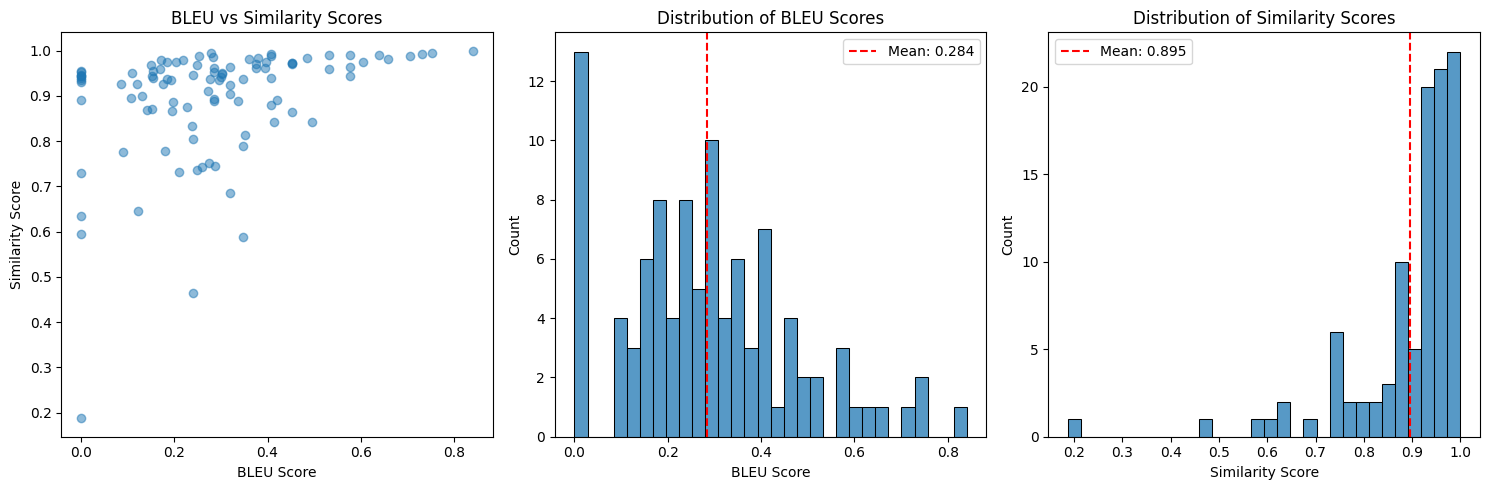

In [92]:
results_list = []
sample_size = 100  # or however many samples you want to analyze
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

for idx in tqdm(random_indices):
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate(kannada_text, similarity_model, use_greedy=True)
    results_list.append(results)

avg_bleu, avg_similarity = analyze_metrics(results_list)

In [95]:
# Generate and save random indices first
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(sentence_similarity), 10, replace=False)

# Test with different repetition penalties
penalties = [1.05, 1.10]

for penalty in penalties:
    print(f"\n=== Testing with Repetition Penalty: {penalty} ===\n")
    
    # Update generation config with new penalty
    greedy_config = GenerationConfig(
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=2,
        repetition_penalty=penalty
    )
    model.generation_config = greedy_config
    
    # Use the same indices for both runs
    for idx in random_indices:
        kannada_text = sentence_similarity['Kannada'][idx]
        results = round_trip_translate(kannada_text, similarity_model, use_greedy=True)
        
        print(f"\nOriginal Sentence Index {idx}:")
        print("Original Kannada:", results['original'])
        print("English Translation:", results['english'])
        print("Back to Kannada:", results['back_translation'])
        print("Similarity Score:", results['similarity_score'])
        print("BLEU Score:", results['bleu_score'])
        print("-" * 80)


=== Testing with Repetition Penalty: 1.05 ===


Original Sentence Index 70097:
Original Kannada: ಇದರ ಹೊರತು ಬೇರೆ ಯಾವುದೇ ಕಾರಣವಿಲ್ಲ
English Translation: Other than that there is no other reason.
Back to Kannada: ಅದಕ್ಕಿಂತ ಬೇರೆ ಕಾರಣವೇನೂ ಇಲ್ಲ.
Similarity Score: 0.8629511594772339
BLEU Score: 0.24880469496253566
--------------------------------------------------------------------------------

Original Sentence Index 29883:
Original Kannada: ಹೀಗೊಂದು ದಟ್ಟ ಸುದ್ದಿ ಎಲ್ಲೆಡೆ ಹಬ್ಬಿದೆ
English Translation: There's a big news everywhere.
Back to Kannada: ಎಲ್ಲೆಡೆ ದೊಡ್ಡ ಸುದ್ದಿ ಇದೆ.
Similarity Score: 0.8688139319419861
BLEU Score: 0.29588031349552907
--------------------------------------------------------------------------------

Original Sentence Index 32765:
Original Kannada: ನಮ್ಮದು ಪುಟ್ಟ ಮನೆ
English Translation: Our little house.
Back to Kannada: ನಮ್ಮ ಸಣ್ಣ ಮನೆ.
Similarity Score: 0.9496356248855591
BLEU Score: 0
--------------------------------------------------------------------------------

Original 

In [16]:
# Take first 50000 sentences (or random sample if you prefer)
n_samples = 25000
sample_indices = np.arange(min(len(sentence_similarity), n_samples))  # Sequential


# Initialize empty lists to store results
results_data = {
    'original_kannada': [],
    'english_translation': [],
    'back_translation': [],
    'bleu_score': [],
    'similarity_score': []
}

for idx in tqdm(sample_indices, desc="Processing sentences"):
    kannada_text = sentence_similarity['Kannada'][idx]
    try:
        results = round_trip_translate(kannada_text, similarity_model, use_greedy=True)
        
        # Store results
        results_data['original_kannada'].append(results['original'])
        results_data['english_translation'].append(results['english'])
        results_data['back_translation'].append(results['back_translation'])
        results_data['bleu_score'].append(results['bleu_score'])
        results_data['similarity_score'].append(results['similarity_score'])
        
        # Optional: Clear CUDA cache periodically
        #if idx % 100 == 0:
            #torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue


# Create DataFrame from results
greedy_results = pd.DataFrame(results_data)

# Save to CSV (optional)
greedy_results.to_csv('greedy_50k.csv', index=False)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total processed sentences: {len(greedy_results)}")
print("\nBLEU Score Statistics:")
print(greedy_results['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(greedy_results['similarity_score'].describe())


Processing sentences: 100%|██████████| 25000/25000 [2:45:20<00:00,  2.52it/s]  


Summary Statistics:
Total processed sentences: 25000

BLEU Score Statistics:
count    25000.000000
mean         0.297845
std          0.206774
min          0.000000
25%          0.163659
50%          0.285744
75%          0.408248
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.897701
std          0.116453
min         -0.016724
25%          0.873283
50%          0.933073
75%          0.967215
max          1.000000
Name: similarity_score, dtype: float64


# Traditional Beam Search

In [14]:
from transformers import GenerationConfig
beam_config = GenerationConfig(
    num_beams=5,  
    do_sample=False,  
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=2,
    length_penalty=1.5,  # Controls output length (>1 favors longer sequences)
    early_stopping=True,
    no_repeat_ngram_size = 2,
    cache_implementation="quantized",
    cache_config={"nbits": 4,"backend":"quanto"}
)

# Update the model's generation config
model.generation_config = beam_config

In [15]:
def evaluate_beam_search(sample_size=100):
    results_list = []
    random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)
    
    for idx in tqdm(random_indices, desc="Processing with Beam Search"):
        kannada_text = sentence_similarity['Kannada'][idx]
        # Set use_greedy=False to use beam search configuration
        results = round_trip_translate(kannada_text, similarity_model, use_greedy=False)
        results_list.append(results)
        
        # Optional: Print intermediate results
        print(f"\nSample result at index {idx}:")
        print(f"Original: {results['original']}")
        print(f"English: {results['english']}")
        print(f"Back translation: {results['back_translation']}")
        print(f"Similarity: {results['similarity_score']:.3f}")
        print(f"BLEU: {results['bleu_score']:.3f}")

In [55]:
print("Running beam search evaluation with 10 samples...")
evaluate_beam_search(sample_size=10)

Running beam search evaluation with 10 samples...


Processing with Beam Search:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]


Sample result at index 21400:
Original: ಅವರಿಗೆ ಮಾತನಾಡಲು ಸಾಧ್ಯವಾಗುವುದಿಲ್ಲ
English: They can't talk.
Back translation: ಅವರು ಮಾತನಾಡಲು ಸಾಧ್ಯವಿಲ್ಲ.
Similarity: 0.962
BLEU: 0.408


Processing with Beam Search:  20%|██        | 2/10 [00:02<00:10,  1.36s/it]


Sample result at index 69902:
Original: ಹಾಗೆ ನೋಡಿದರೆ ಭಾರತದಲ್ಲಿ ಕೌಶಲ್ಯಾಭಿವೃದ್ಧಿ ಎನ್ನುವುದು ಹಳೆಯ ಸಂಪ್ರದಾಯವೇ ಆಗಿದ್ದು ಇದಕ್ಕೆ ಪ್ರತಿಯೊಂದು ಸರಕಾರವೂ ತನ್ನದೇ ಆದ ಕಾಣಿಕೆಯನ್ನು ನೀಡುತ್ತ ಬಂದಿದೆ
English: So it seems that skill development in India is an old tradition and every government has been making its own contribution to this.
Back translation: ಆದ್ದರಿಂದ ಭಾರತದಲ್ಲಿ ಕೌಶಲ್ಯ ಅಭಿವೃದ್ಧಿಯು ಹಳೆಯ ಸಂಪ್ರದಾಯವಾಗಿದೆ ಮತ್ತು ಪ್ರತಿ ಸರ್ಕಾರವೂ ಇದಕ್ಕೆ ತನ್ನದೇ ಆದ ಕೊಡುಗೆ ನೀಡುತ್ತಿದೆ ಎಂದು ತೋರುತ್ತದೆ.
Similarity: 0.974
BLEU: 0.117


Processing with Beam Search:  30%|███       | 3/10 [00:03<00:08,  1.27s/it]


Sample result at index 40972:
Original: ಸತ್ಯ ಕ್ರೈಸ್ತರಲ್ಲಿ ನಿಜವಾದ ಪ್ರೀತಿ ಇರುತ್ತದೆ
English: There is true love among true Christians.
Back translation: ನಿಜವಾದ ಕ್ರೈಸ್ತರ ನಡುವೆ ನಿಜವಾದ ಪ್ರೀತಿ ಇದೆ.
Similarity: 0.901
BLEU: 0.273


Processing with Beam Search:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]


Sample result at index 17626:
Original: ದಿಲ್ಲಿಯಲ್ಲಿ ಇದೇ ಮೊದಲ ಬಾರಿ ದೇಶದ ನಾನಾ ಮೂಲೆಯಿಂದ ಆಗಮಿಸಿದ ಮೂಲವಾಸಿ ಸೋದರರು ಮತ್ತು ಸೋದರಿಯರೊಂದಿಗೆ ದೀಪಾವಳಿ ಹಬ್ಬವನ್ನು ಆಚರಿಸಲಾಗುತ್ತಿದೆ
English: This is the first time that Diwali festival is being celebrated in Delhi with indigenous brothers and sisters from different parts of the country.
Back translation: ಇದೇ ಮೊದಲ ಬಾರಿಗೆ ದೆಹಲಿಯಲ್ಲಿ ದೇಶದ ವಿವಿಧ ಭಾಗಗಳಿಂದ ಸ್ಥಳೀಯ ಸಹೋದರ ಸಹೋದರಿಯರೊಂದಿಗೆ ದೀಪಾವಳಿ ಉತ್ಸವವನ್ನು ಆಚರಿಸಲಾಗುತ್ತಿದೆ.
Similarity: 0.939
BLEU: 0.118


Processing with Beam Search:  50%|█████     | 5/10 [00:07<00:08,  1.65s/it]


Sample result at index 5863:
Original: ಫಿರ್‌ ಹೇರಾ ಫೆರಿ ಖ್ಯಾತಿಯ ನಿರ್ದೇಶಕ ನೀರಜ್‌ ವೋರಾ ವಿಧಿವಶ
English: The director of FIR HEYRA FERI KHAYATI Neeraj Voora is deceased.
Back translation: ಫಿರ್ ಹೇರಾ ಫೆರಿ ಖಾಯತಿ ನಿರ್ದೇಶಕ ನೀರಾಜ್ ವೂರಾ ಮೃತಪಟ್ಟಿದ್ದಾರೆ.
Similarity: 0.898
BLEU: 0.217


Processing with Beam Search:  60%|██████    | 6/10 [00:08<00:05,  1.31s/it]


Sample result at index 25613:
Original: ಯಾವ ಆಹಾರಧಾನ್ಯ ತಿನ್ನುವುದು?
English: What kind of food to eat?
Back translation: ಯಾವ ರೀತಿಯ ಆಹಾರವನ್ನು ತಿನ್ನಬೇಕು?
Similarity: 0.891
BLEU: 0.319


Processing with Beam Search:  70%|███████   | 7/10 [00:10<00:04,  1.48s/it]


Sample result at index 57673:
Original: ಅನಿಲ್ ಕುಂಬ್ಳೆ ಇನ್ನಿಂಗ್ಸ್‌ವೊಂದರಲ್ಲೇ ಪಾಕಿಸ್ತಾನದ ವಿರುದ್ಧ ತಂಡದ ಎಲ್ಲ  ವಿಕೆಟ್ ಪಡೆದು ವಿಶ್ವದ ಎರಡನೇ ಬೌಲರ್ ಎಂದೆನಿಸಿಕೊಂಡಿದ್ದಾರೆ
English: Anil Kumble is the second bowler in the world to take all the wickets in a match against Pakistan
Back translation: ಪಾಕಿಸ್ತಾನದ ವಿರುದ್ಧದ ಪಂದ್ಯದಲ್ಲಿ ಎಲ್ಲಾ ವಿಕೆಟ್ ಗಳಿಸಿದ ವಿಶ್ವದ ಎರಡನೇ ಬೌಲರ್ ಅನಿಲ್ ಕುಂಬ್ಲೆ
Similarity: 0.943
BLEU: 0.200


Processing with Beam Search:  80%|████████  | 8/10 [00:10<00:02,  1.20s/it]


Sample result at index 13561:
Original: ಅಲ್ಲೊಂದು ಚರ್ಚೆ ನಡೆಯುತ್ತಿತ್ತು
English: There was a discussion going on.
Back translation: ಚರ್ಚೆ ನಡೆಯುತ್ತಿತ್ತು.
Similarity: 0.947
BLEU: 0.303


Processing with Beam Search:  90%|█████████ | 9/10 [00:11<00:01,  1.15s/it]


Sample result at index 36554:
Original: ಬೆಂಗಳೂರಿನಲ್ಲಿ ಸಾಫ್ಟ್‌ವೇರ್ ಎಂಜಿನಿಯರ್ ಉದ್ಯೋಗ
English: Employment of software engineers in Bangalore
Back translation: ಬೆಂಗಳೂರು ನಲ್ಲಿ ಸಾಫ್ಟ್ವೇರ್ ಎಂಜಿನಿಯರ್ ಗಳ ಉದ್ಯೋಗ
Similarity: 0.965
BLEU: 0.230


Processing with Beam Search: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Sample result at index 10835:
Original: ನಿಮ್ಮ ಅಮೂಲ್ಯ ಸಮಯವನ್ನು ವ್ಯರ್ಥ ಮಾಡಬೇಡಿ
English: Don't waste your precious time
Back translation: ನಿಮ್ಮ ಅಮೂಲ್ಯವಾದ ಸಮಯವನ್ನು ವ್ಯರ್ಥ ಮಾಡಬೇಡಿ
Similarity: 0.994
BLEU: 0.532


Running beam search evaluation with 100 samples...


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average BLEU Score: 0.309
Average Similarity Score: 0.916

Detailed Statistics:

BLEU Score Statistics:
count    100.000000
mean       0.308591
std        0.207205
min        0.000000
25%        0.193049
50%        0.303265
75%        0.408248
max        1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    100.000000
mean       0.916234
std        0.072438
min        0.680392
25%        0.889482
50%        0.941690
75%        0.966686
max        1.000000
Name: similarity_score, dtype: float64


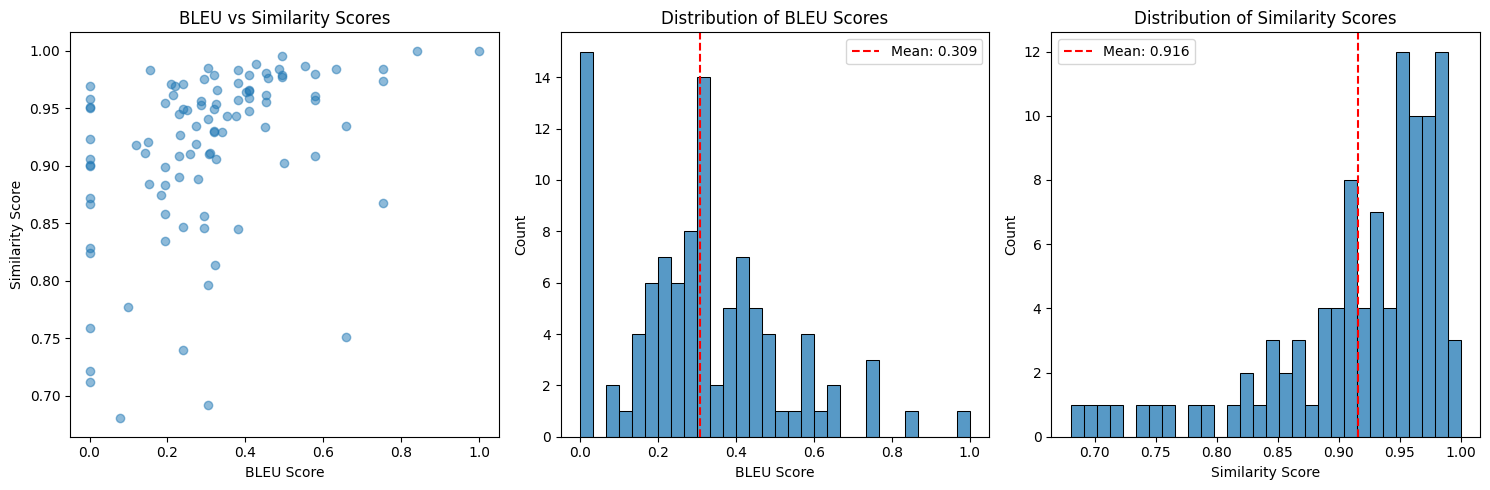

In [53]:
print("Running beam search evaluation with 100 samples...")
results_list = []
sample_size = 100
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

for idx in tqdm(random_indices):
    kannada_text = sentence_similarity['Kannada'][idx]
    # Removed num_return_sequences parameter
    results = round_trip_translate(kannada_text, similarity_model, use_greedy=False)
    results_list.append(results)  # Changed to append since results is now a single result

# Use our existing analyze_metrics function to visualize results
avg_bleu, avg_similarity = analyze_metrics(results_list)

# Additional summary statistics
beam_results_df = pd.DataFrame(results_list)
print("\nDetailed Statistics:")
print("\nBLEU Score Statistics:")
print(beam_results_df['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(beam_results_df['similarity_score'].describe())

In [ ]:
n_samples_part1 = 12500
sentence_similarity_part1 = sentence_similarity.iloc[:n_samples_part1]

results_data = {
    'original': [],  # Changed from 'original_kannada'
    'english': [],  # Changed from 'english_translation'
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part1.index, desc="Processing first 12.5k sentences"):
    kannada_text = sentence_similarity_part1['Kannada'][idx]
    try:
        results = round_trip_translate(kannada_text, similarity_model, use_greedy=False)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save first part
beam_search_results_part1 = pd.DataFrame(results_data)
beam_search_results_part1.to_csv('beam_12.5k_part1.csv', index=False)


Processing first 12.5k sentences: 100%|█████████▉| 12499/12500 [2:31:38<00:00,  1.70it/s]  

In [16]:
beam_search_results_part1 = pd.read_csv('beam_12.5k_part1.csv')

# Part 2: Process second 12.5k sentences
n_samples_part2 = 12500
sentence_similarity_part2 = sentence_similarity.iloc[n_samples_part2:n_samples_part2 + n_samples_part2]

results_data = {
    'original': [],  # Changed from 'original_kannada'
    'english': [],  # Changed from 'english_translation'
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part2.index, desc="Processing second 12.5k sentences"):
    kannada_text = sentence_similarity_part2['Kannada'][idx]
    try:
        results = round_trip_translate(kannada_text, similarity_model, use_greedy=False)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

Processing second 12.5k sentences: 100%|██████████| 12500/12500 [1:53:35<00:00,  1.83it/s] 


In [17]:
# Save second part
beam_search_results_part2 = pd.DataFrame(results_data)
beam_search_results_part2.to_csv('beam_12.5k_part2.csv', index=False)

# Combine both parts
beam_search_results = pd.concat([beam_search_results_part1, beam_search_results_part2], ignore_index=True)
beam_search_results.to_csv('beam25k.csv', index=False)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total processed sentences: {len(beam_search_results)}")
print("\nBLEU Score Statistics:")
print(beam_search_results['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(beam_search_results['similarity_score'].describe())


Summary Statistics:
Total processed sentences: 25000

BLEU Score Statistics:
count    25000.000000
mean         0.306174
std          0.200710
min          0.000000
25%          0.182778
50%          0.292523
75%          0.408248
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.913302
std          0.092391
min         -0.042925
25%          0.891857
50%          0.939045
75%          0.968488
max          1.000000
Name: similarity_score, dtype: float64


# Introduce Randomness -- Top-K Sampling 

In [15]:
from transformers import GenerationConfig
# Define Top-K sampling configuration
topk_config = GenerationConfig(
    do_sample=True,  
    top_k=35,        # Consider top 50 tokens
    temperature=0.4,  #try ranges mentioned in docx
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=2,
    repetition_penalty=1.0,
    length_penalty=1.0,
    #early_stopping=True,
    cache_implementation="quantized",
    cache_config={"nbits": 4, "backend": "quanto"}
)

# Update the model's generation config
model.generation_config = topk_config

In [16]:
def round_trip_translate_topk(kannada_text, similarity_model):
    input_length = len(tokenizer.encode(kannada_text))
    max_tokens = input_length + 10
    
    # Step 1: Kannada to English
    inputs = tokenizer(kannada_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[ENGLISH_CODE],
        max_new_tokens=max_tokens,
        # Using top-k sampling configuration that's already set in model.generation_config
    )
    english_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Step 2: English back to Kannada
    inputs = tokenizer(english_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[KANNADA_CODE],
        max_new_tokens=max_tokens,
        # Using same top-k sampling configuration
    )
    back_to_kannada = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Calculate metrics
    similarity_score, bleu_score = calculate_metrics(kannada_text, back_to_kannada, similarity_model)
    
    return {
        'original': kannada_text,
        'english': english_text,
        'back_translation': back_to_kannada,
        'similarity_score': similarity_score,
        'bleu_score': bleu_score
    }

In [17]:
# Generate 10 random samples
np.random.seed(42)  # For reproducibility
sample_size = 10
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

results_list = []

print("=== Testing Top-K Sampling Round Trip Translation ===\n")

for idx in random_indices:
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_topk(kannada_text, similarity_model)
    results_list.append(results)
    
    # Print results for each sample
    print(f"\nSample {idx}:")
    print("Original Kannada:", results['original'])
    print("English Translation:", results['english'])
    print("Back to Kannada:", results['back_translation'])
    print("Similarity Score:", f"{results['similarity_score']:.3f}")
    print("BLEU Score:", f"{results['bleu_score']:.3f}")
    print("-" * 80)

# Calculate and display average metrics
avg_similarity = np.mean([r['similarity_score'] for r in results_list])
avg_bleu = np.mean([r['bleu_score'] for r in results_list])

print("\nSummary Statistics:")
print(f"Average Similarity Score: {avg_similarity:.3f}")
print(f"Average BLEU Score: {avg_bleu:.3f}")

=== Testing Top-K Sampling Round Trip Translation ===


Sample 70097:
Original Kannada: ಇದರ ಹೊರತು ಬೇರೆ ಯಾವುದೇ ಕಾರಣವಿಲ್ಲ
English Translation: Other than that there is no other reason.
Back to Kannada: ಅದಕ್ಕಿಂತ ಬೇರೆ ಕಾರಣವೇನೂ ಇಲ್ಲ.
Similarity Score: 0.863
BLEU Score: 0.249
--------------------------------------------------------------------------------

Sample 29883:
Original Kannada: ಹೀಗೊಂದು ದಟ್ಟ ಸುದ್ದಿ ಎಲ್ಲೆಡೆ ಹಬ್ಬಿದೆ
English Translation: So a big news has spread everywhere.
Back to Kannada: ಹಾಗಾಗಿ, ಎಲ್ಲೆಡೆ ದೊಡ್ಡ ಸುದ್ದಿ ಹರಡಿದೆ.
Similarity Score: 0.941
BLEU Score: 0.286
--------------------------------------------------------------------------------

Sample 32765:
Original Kannada: ನಮ್ಮದು ಪುಟ್ಟ ಮನೆ
English Translation: Our little house.
Back to Kannada: ನಮ್ಮ ಸಣ್ಣ ಮನೆ.
Similarity Score: 0.950
BLEU Score: 0.000
--------------------------------------------------------------------------------

Sample 46029:
Original Kannada: ನಿಮ್ಮ ಕನಸುಗಳನ್ನು ಸಾಕಾರಗೊಳಿಸಿಕೊಳ್ಳಿ
English Translation: Make your d

Running Top-K sampling evaluation with 100 samples...


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average BLEU Score: 0.300
Average Similarity Score: 0.892

Detailed Statistics:

BLEU Score Statistics:
count    100.000000
mean       0.299883
std        0.174382
min        0.000000
25%        0.181796
50%        0.303265
75%        0.408248
max        0.803428
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    100.000000
mean       0.891864
std        0.144368
min       -0.019112
25%        0.888325
50%        0.925244
75%        0.963159
max        0.999018
Name: similarity_score, dtype: float64


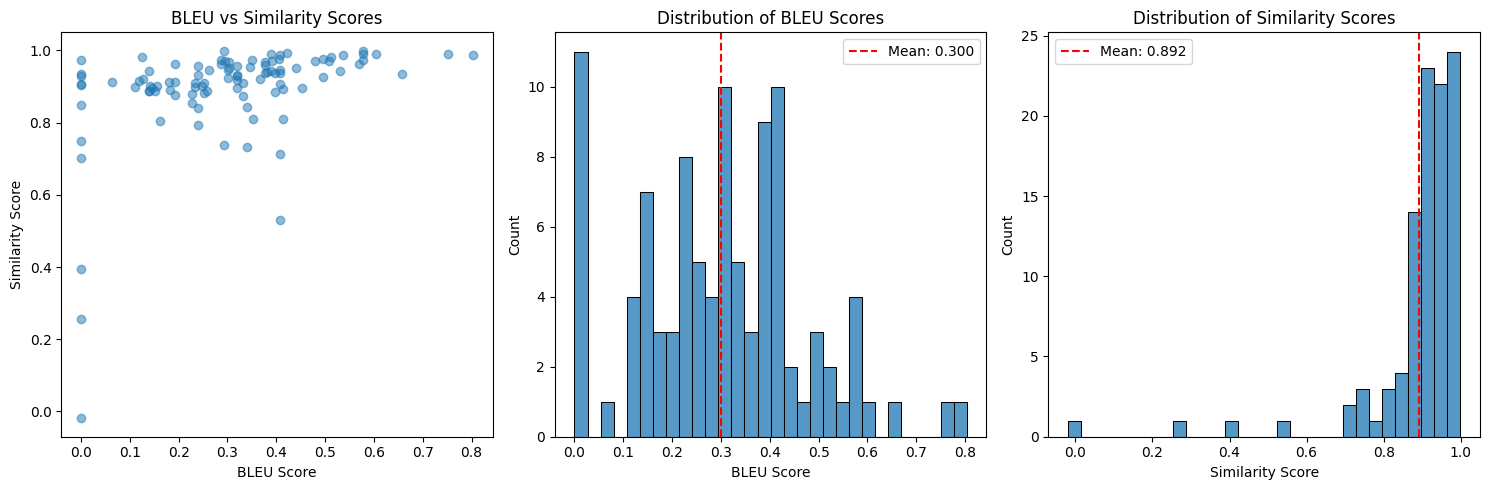

In [18]:
# Run Top-K sampling evaluation with 100 samples
print("Running Top-K sampling evaluation with 100 samples...")
results_list = []
sample_size = 100
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

for idx in tqdm(random_indices):
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_topk(kannada_text, similarity_model)
    results_list.append(results)

# Use our existing analyze_metrics function to visualize results
avg_bleu, avg_similarity = analyze_metrics(results_list)

# Additional summary statistics
topk_results_df = pd.DataFrame(results_list)
print("\nDetailed Statistics:")
print("\nBLEU Score Statistics:")
print(topk_results_df['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(topk_results_df['similarity_score'].describe())

In [19]:
# Process first 12.5k sentences
n_samples_part1 = 12500
sentence_similarity_part1 = sentence_similarity.iloc[:n_samples_part1]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part1.index, desc="Processing first 12.5k sentences"):
    kannada_text = sentence_similarity_part1['Kannada'][idx]
    try:
        results = round_trip_translate_topk(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save first part
topk_results_part1 = pd.DataFrame(results_data)
topk_results_part1.to_csv('topk_12.5k_part1.csv', index=False)


Processing first 12.5k sentences: 100%|██████████| 12500/12500 [1:28:19<00:00,  2.36it/s] 


In [20]:

# Process second 12.5k sentences
n_samples_part2 = 12500
sentence_similarity_part2 = sentence_similarity.iloc[n_samples_part1:n_samples_part1 + n_samples_part2]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part2.index, desc="Processing second 12.5k sentences"):
    kannada_text = sentence_similarity_part2['Kannada'][idx]
    try:
        results = round_trip_translate_topk(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save second part
topk_results_part2 = pd.DataFrame(results_data)
topk_results_part2.to_csv('topk_12.5k_part2.csv', index=False)


Processing second 12.5k sentences: 100%|██████████| 12500/12500 [1:27:47<00:00,  2.37it/s] 


In [21]:
# Combine both parts
topk_results = pd.concat([topk_results_part1, topk_results_part2], ignore_index=True)
topk_results.to_csv('topk25k.csv', index=False)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total processed sentences: {len(topk_results)}")
print("\nBLEU Score Statistics:")
print(topk_results['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(topk_results['similarity_score'].describe())


Summary Statistics:
Total processed sentences: 25000

BLEU Score Statistics:
count    25000.000000
mean         0.275417
std          0.192744
min          0.000000
25%          0.153090
50%          0.254066
75%          0.379918
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.888079
std          0.123039
min         -0.048084
25%          0.862981
50%          0.925338
75%          0.960791
max          1.000000
Name: similarity_score, dtype: float64


# Top-P Sampling (Nucleus Sampling)

In [16]:
# Define Top-P (nucleus) sampling configuration
topP_config = GenerationConfig(
    do_sample=True,          
    top_p=0.95,             # Nucleus sampling threshold (0-1)
    temperature=0.4,        
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=2,
    repetition_penalty=1.0,
    length_penalty=1.0,
    #early_stopping=True,
    cache_implementation="quantized",
    cache_config={"nbits": 4, "backend": "quanto"}
)

# Update the model's generation config
model.generation_config = topP_config

In [17]:
def round_trip_translate_topP(kannada_text, similarity_model):
    input_length = len(tokenizer.encode(kannada_text))
    max_tokens = input_length + 10
    
    # Step 1: Kannada to English
    inputs = tokenizer(kannada_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[ENGLISH_CODE],
        max_new_tokens=max_tokens,
        # Using top-p sampling configuration from model.generation_config
    )
    english_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Step 2: English back to Kannada
    inputs = tokenizer(english_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[KANNADA_CODE],
        max_new_tokens=max_tokens,
        # Using same top-p sampling configuration
    )
    back_to_kannada = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Calculate metrics
    similarity_score, bleu_score = calculate_metrics(kannada_text, back_to_kannada, similarity_model)
    
    return {
        'original': kannada_text,
        'english': english_text,
        'back_translation': back_to_kannada,
        'similarity_score': similarity_score,
        'bleu_score': bleu_score
    }

In [16]:
# Generate 10 random samples
np.random.seed(42)  # For reproducibility
sample_size = 10
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

results_list = []

print("=== Testing Top-P (Nucleus) Sampling Round Trip Translation ===\n")

for idx in random_indices:
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_topP(kannada_text, similarity_model)
    results_list.append(results)
    
    # Print results for each sample
    print(f"\nSample {idx}:")
    print("Original Kannada:", results['original'])
    print("English Translation:", results['english'])
    print("Back to Kannada:", results['back_translation'])
    print("Similarity Score:", f"{results['similarity_score']:.3f}")
    print("BLEU Score:", f"{results['bleu_score']:.3f}")
    print("-" * 80)

# Calculate and display average metrics
avg_similarity = np.mean([r['similarity_score'] for r in results_list])
avg_bleu = np.mean([r['bleu_score'] for r in results_list])

print("\nSummary Statistics:")
print(f"Average Similarity Score: {avg_similarity:.3f}")
print(f"Average BLEU Score: {avg_bleu:.3f}")

=== Testing Top-P (Nucleus) Sampling Round Trip Translation ===


Sample 70097:
Original Kannada: ಇದರ ಹೊರತು ಬೇರೆ ಯಾವುದೇ ಕಾರಣವಿಲ್ಲ
English Translation: Other than that there is no other reason.
Back to Kannada: ಅದಕ್ಕಿಂತ ಬೇರೆ ಕಾರಣವೇ ಇಲ್ಲ.
Similarity Score: 0.889
BLEU Score: 0.249
--------------------------------------------------------------------------------

Sample 29883:
Original Kannada: ಹೀಗೊಂದು ದಟ್ಟ ಸುದ್ದಿ ಎಲ್ಲೆಡೆ ಹಬ್ಬಿದೆ
English Translation: There's a lot of news everywhere.
Back to Kannada: ಎಲ್ಲೆಡೆ ಸುದ್ದಿ ತುಂಬಿದೆ.
Similarity Score: 0.872
BLEU Score: 0.249
--------------------------------------------------------------------------------

Sample 32765:
Original Kannada: ನಮ್ಮದು ಪುಟ್ಟ ಮನೆ
English Translation: Our little house
Back to Kannada: ನಮ್ಮ ಸಣ್ಣ ಮನೆ
Similarity Score: 0.958
BLEU Score: 0.408
--------------------------------------------------------------------------------

Sample 46029:
Original Kannada: ನಿಮ್ಮ ಕನಸುಗಳನ್ನು ಸಾಕಾರಗೊಳಿಸಿಕೊಳ್ಳಿ
English Translation: Make your dreams come

Running Top-P sampling evaluation with 100 samples...


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average BLEU Score: 0.304
Average Similarity Score: 0.899

Detailed Statistics:

BLEU Score Statistics:
count    100.000000
mean       0.304139
std        0.182056
min        0.000000
25%        0.193633
50%        0.304289
75%        0.408248
max        0.840896
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    100.000000
mean       0.898527
std        0.101525
min        0.375561
25%        0.886051
50%        0.924892
75%        0.963209
max        1.000000
Name: similarity_score, dtype: float64


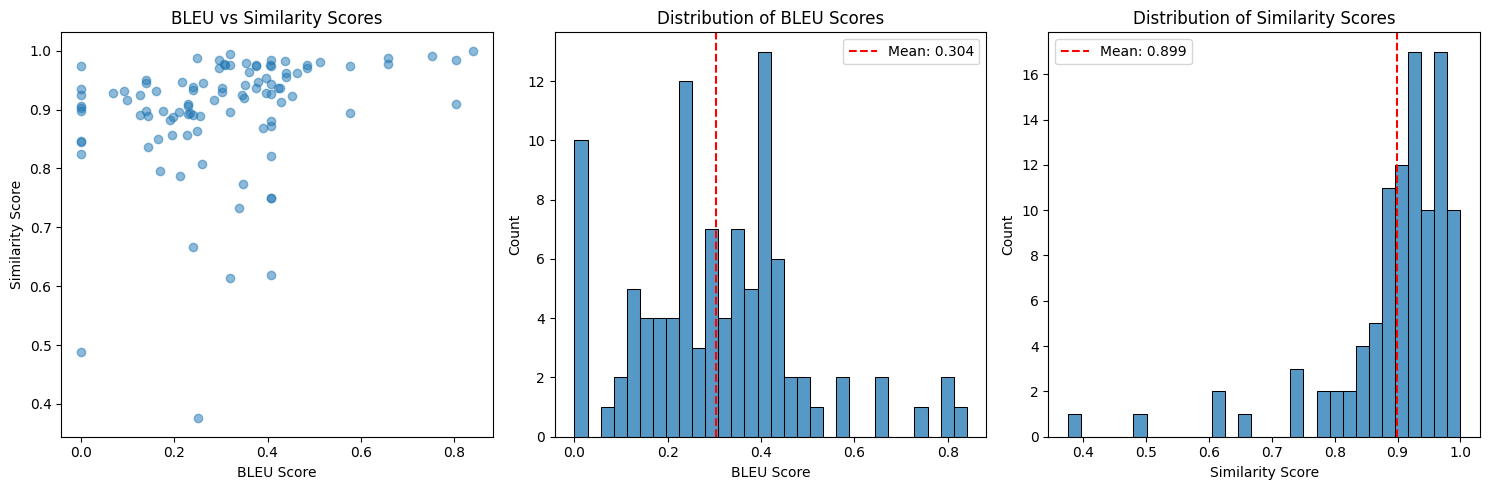

In [17]:
# Run Top-P sampling evaluation with 100 samples
print("Running Top-P sampling evaluation with 100 samples...")
results_list = []
sample_size = 100
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

for idx in tqdm(random_indices):
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_topP(kannada_text, similarity_model)
    results_list.append(results)

# Use our existing analyze_metrics function to visualize results
avg_bleu, avg_similarity = analyze_metrics(results_list)

# Additional summary statistics
topP_results_df = pd.DataFrame(results_list)
print("\nDetailed Statistics:")
print("\nBLEU Score Statistics:")
print(topP_results_df['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(topP_results_df['similarity_score'].describe())

In [16]:
# Process first 12.5k sentences
n_samples_part1 = 12500
sentence_similarity_part1 = sentence_similarity.iloc[:n_samples_part1]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part1.index, desc="Processing first 12.5k sentences"):
    kannada_text = sentence_similarity_part1['Kannada'][idx]
    try:
        results = round_trip_translate_topP(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save first part
topP_results_part1 = pd.DataFrame(results_data)
topP_results_part1.to_csv('topP_12.5k_part1.csv', index=False)


Processing first 12.5k sentences: 100%|██████████| 12500/12500 [2:52:23<00:00,  1.21it/s]  


In [18]:

# Process second 12.5k sentences
n_samples_part2 = 12500
sentence_similarity_part2 = sentence_similarity.iloc[n_samples_part2:n_samples_part2 + n_samples_part2]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part2.index, desc="Processing second 12.5k sentences"):
    kannada_text = sentence_similarity_part2['Kannada'][idx]
    try:
        results = round_trip_translate_topP(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save second part
topP_results_part2 = pd.DataFrame(results_data)
topP_results_part2.to_csv('topP_12.5k_part2.csv', index=False)


Processing second 12.5k sentences: 100%|██████████| 12500/12500 [1:31:44<00:00,  2.27it/s] 


In [19]:
topP_results_part1 = pd.read_csv('topP_12.5k_part1.csv')

# Combine both parts
topP_results = pd.concat([topP_results_part1, topP_results_part2], ignore_index=True)
topP_results.to_csv('topP_25k.csv', index=False)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total processed sentences: {len(topP_results)}")
print("\nBLEU Score Statistics:")
print(topP_results['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(topP_results['similarity_score'].describe())


Summary Statistics:
Total processed sentences: 25000

BLEU Score Statistics:
count    25000.000000
mean         0.280657
std          0.193987
min          0.000000
25%          0.160865
50%          0.269702
75%          0.397635
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.891858
std          0.120081
min         -0.123527
25%          0.868192
50%          0.927705
75%          0.962297
max          1.000000
Name: similarity_score, dtype: float64


# Top-K + Top-P

In [14]:
# Define combined Top-P and Top-K sampling configuration
combinedsampling_config = GenerationConfig(
    do_sample=True,          # Enable sampling
    top_k=35,               # Limit to top 50 tokens
    top_p=0.99,            # Nucleus sampling threshold
    temperature=0.95,        # Standard temperature for creativity
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=2,
    repetition_penalty=1.0,
    length_penalty=1.0,
    #early_stopping=True,
    cache_implementation="quantized",
    cache_config={"nbits": 4, "backend": "quanto"}
)

# Update the model's generation config
model.generation_config = combinedsampling_config

In [15]:
def round_trip_translate_combined(kannada_text, similarity_model):
    input_length = len(tokenizer.encode(kannada_text))
    max_tokens = input_length + 10
    
    # Step 1: Kannada to English
    inputs = tokenizer(kannada_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[ENGLISH_CODE],
        max_new_tokens=max_tokens,
        # Using combined top-p and top-k sampling configuration from model.generation_config
    )
    english_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Step 2: English back to Kannada
    inputs = tokenizer(english_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[KANNADA_CODE],
        max_new_tokens=max_tokens,
        # Using same combined sampling configuration
    )
    back_to_kannada = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    
    # Calculate metrics
    similarity_score, bleu_score = calculate_metrics(kannada_text, back_to_kannada, similarity_model)
    
    return {
        'original': kannada_text,
        'english': english_text,
        'back_translation': back_to_kannada,
        'similarity_score': similarity_score,
        'bleu_score': bleu_score
    }

In [98]:
# Generate 10 random samples
np.random.seed(42)  # For reproducibility
sample_size = 10
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

results_list = []

print("=== Testing Combined Top-P and Top-K Sampling Round Trip Translation ===\n")

for idx in random_indices:
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_combined(kannada_text, similarity_model)
    results_list.append(results)
    
    # Print results for each sample
    print(f"\nSample {idx}:")
    print("Original Kannada:", results['original'])
    print("English Translation:", results['english'])
    print("Back to Kannada:", results['back_translation'])
    print("Similarity Score:", f"{results['similarity_score']:.3f}")
    print("BLEU Score:", f"{results['bleu_score']:.3f}")
    print("-" * 80)

# Calculate and display average metrics
avg_similarity = np.mean([r['similarity_score'] for r in results_list])
avg_bleu = np.mean([r['bleu_score'] for r in results_list])

print("\nSummary Statistics:")
print(f"Average Similarity Score: {avg_similarity:.3f}")
print(f"Average BLEU Score: {avg_bleu:.3f}")

=== Testing Combined Top-P and Top-K Sampling Round Trip Translation ===


Sample 70097:
Original Kannada: ಇದರ ಹೊರತು ಬೇರೆ ಯಾವುದೇ ಕಾರಣವಿಲ್ಲ
English Translation: Other than that there is no reason.
Back to Kannada: ಇದಕ್ಕೆ ಹೊರತಾಗಿ ಕಾರಣವೂ ಇರಲಾರದು.
Similarity Score: 0.885
BLEU Score: 0.000
--------------------------------------------------------------------------------

Sample 29883:
Original Kannada: ಹೀಗೊಂದು ದಟ್ಟ ಸುದ್ದಿ ಎಲ್ಲೆಡೆ ಹಬ್ಬಿದೆ
English Translation: Like that. A big news spread all around.
Back to Kannada: ಅಲ್ಲೇ ಒಂದು ಸುದ್ದಿ ಹರಡಿತು.
Similarity Score: 0.720
BLEU Score: 0.249
--------------------------------------------------------------------------------

Sample 32765:
Original Kannada: ನಮ್ಮದು ಪುಟ್ಟ ಮನೆ
English Translation: This is our little home.
Back to Kannada: ಇದು ನಮ್ಮ ಚಿಕ್ಕ ಮನೆಯಲ್ಲಿ.
Similarity Score: 0.881
BLEU Score: 0.000
--------------------------------------------------------------------------------

Sample 46029:
Original Kannada: ನಿಮ್ಮ ಕನಸುಗಳನ್ನು ಸಾಕಾರಗೊಳಿಸಿಕೊಳ್ಳಿ
English

Running combined Top-P and Top-K sampling evaluation with 100 samples...


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average BLEU Score: 0.181
Average Similarity Score: 0.793

Detailed Statistics:

BLEU Score Statistics:
count    100.000000
mean       0.180716
std        0.158205
min        0.000000
25%        0.000000
50%        0.182574
75%        0.302138
max        0.577350
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    100.000000
mean       0.792539
std        0.204042
min        0.156704
25%        0.737907
50%        0.886454
75%        0.924485
max        0.986199
Name: similarity_score, dtype: float64


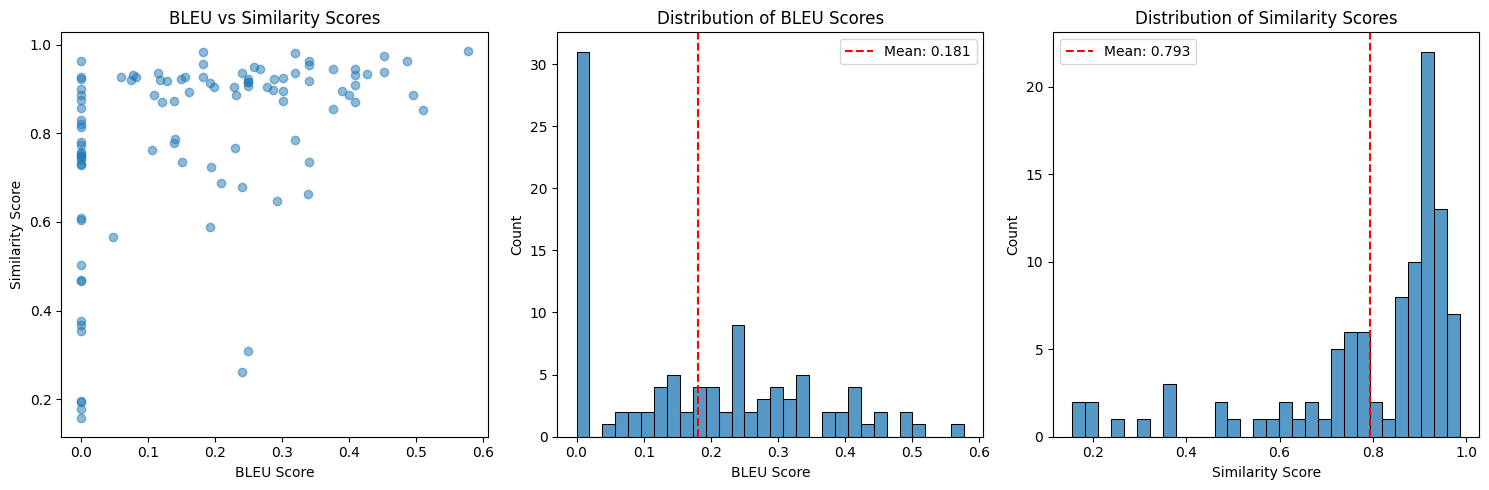

In [99]:
# Run combined sampling evaluation with 100 samples
print("Running combined Top-P and Top-K sampling evaluation with 100 samples...")
results_list = []
sample_size = 100
random_indices = np.random.choice(len(sentence_similarity), sample_size, replace=False)

for idx in tqdm(random_indices):
    kannada_text = sentence_similarity['Kannada'][idx]
    results = round_trip_translate_combined(kannada_text, similarity_model)
    results_list.append(results)

# Use our existing analyze_metrics function to visualize results
avg_bleu, avg_similarity = analyze_metrics(results_list)

# Additional summary statistics
combined_results_df = pd.DataFrame(results_list)
print("\nDetailed Statistics:")
print("\nBLEU Score Statistics:")
print(combined_results_df['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(combined_results_df['similarity_score'].describe())

In [18]:
# Process first 12.5k sentences
n_samples_part1 = 12500
sentence_similarity_part1 = sentence_similarity.iloc[:n_samples_part1]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part1.index, desc="Processing first 12.5k sentences"):
    kannada_text = sentence_similarity_part1['Kannada'][idx]
    try:
        results = round_trip_translate_combined(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save first part
combined_results_part1 = pd.DataFrame(results_data)
combined_results_part1.to_csv('combined_12.5k_part1.csv', index=False)


Processing first 12.5k sentences: 100%|██████████| 12500/12500 [1:36:27<00:00,  2.16it/s] 


In [16]:
# Process second 12.5k sentences

n_samples_part2 = 12500
sentence_similarity_part2 = sentence_similarity.iloc[n_samples_part2:n_samples_part2 + n_samples_part2]

results_data = {
    'original': [],
    'english': [],
    'back_translation': [],
    'similarity_score': [],
    'bleu_score': []
}

for idx in tqdm(sentence_similarity_part2.index, desc="Processing second 12.5k sentences"):
    kannada_text = sentence_similarity_part2['Kannada'][idx]
    try:
        results = round_trip_translate_combined(kannada_text, similarity_model)
        for key in results_data:
            results_data[key].append(results[key])
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")
        continue

# Save second part
combined_results_part2 = pd.DataFrame(results_data)
combined_results_part2.to_csv('combined_12.5k_part2.csv', index=False)


Processing second 12.5k sentences: 100%|██████████| 12500/12500 [1:34:06<00:00,  2.21it/s] 


In [17]:
combined_results_part1=pd.read_csv('combined_12.5k_part1.csv')
# Combine both parts
combined_results = pd.concat([combined_results_part1, combined_results_part2], ignore_index=True)
combined_results.to_csv('combined_25k.csv', index=False)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total processed sentences: {len(combined_results)}")
print("\nBLEU Score Statistics:")
print(combined_results['bleu_score'].describe())
print("\nSimilarity Score Statistics:")
print(combined_results['similarity_score'].describe())


Summary Statistics:
Total processed sentences: 25000

BLEU Score Statistics:
count    25000.000000
mean         0.179334
std          0.163779
min          0.000000
25%          0.000000
50%          0.161499
75%          0.288368
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.769630
std          0.201426
min         -0.045963
25%          0.689707
50%          0.834181
75%          0.915030
max          1.000000
Name: similarity_score, dtype: float64


# Analying Data and Reducing Data

In [56]:
# Read all the CSV files
greedy_results = pd.read_csv('greedy_25k.csv')
beam_results = pd.read_csv('beam25k.csv')
topk_results = pd.read_csv('topk25k.csv')
topp_results = pd.read_csv('topP_25k.csv')
combined_results = pd.read_csv('combined_25k.csv')

# Define consistent column names
consistent_columns = ['original_kannada', 'english_translation', 'back_translation', 'similarity_score', 'bleu_score']

# Set column names for each DataFrame
greedy_results.columns = consistent_columns
beam_results.columns = consistent_columns
topk_results.columns = consistent_columns
topp_results.columns = consistent_columns
combined_results.columns = consistent_columns

In [15]:
# Display first 10 examples with all configurations
for i in range(10):
    print(f"\n=== Example {i+1} ===")
    print(f"\nOriginal Kannada:")
    print(greedy_results['original_kannada'][i])
    
    print("\nParaphrases from different configurations:")
    print("\n1. Greedy Search:")
    print(greedy_results['back_translation'][i])
    print(f"BLEU: {greedy_results['bleu_score'][i]:.3f}, Similarity: {greedy_results['similarity_score'][i]:.3f}")
    
    print("\n2. Beam Search:")
    print(beam_results['back_translation'][i])
    print(f"BLEU: {beam_results['bleu_score'][i]:.3f}, Similarity: {beam_results['similarity_score'][i]:.3f}")
    
    print("\n3. Top-K Sampling:")
    print(topk_results['back_translation'][i])
    print(f"BLEU: {topk_results['bleu_score'][i]:.3f}, Similarity: {topk_results['similarity_score'][i]:.3f}")
    
    print("\n4. Top-P Sampling:")
    print(topp_results['back_translation'][i])
    print(f"BLEU: {topp_results['bleu_score'][i]:.3f}, Similarity: {topp_results['similarity_score'][i]:.3f}")
    
    print("\n5. Combined Top-P & Top-K:")
    print(combined_results['back_translation'][i])
    print(f"BLEU: {combined_results['bleu_score'][i]:.3f}, Similarity: {combined_results['similarity_score'][i]:.3f}")
    
    print("\n" + "="*80)


=== Example 1 ===

Original Kannada:
ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡುತ್ತಿರುತ್ತವೆ

Paraphrases from different configurations:

1. Greedy Search:
ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳು
BLEU: 0.352, Similarity: 0.924

2. Beam Search:
ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಬಹಳಷ್ಟು ವಿಡಿಯೋಗಳಿವೆ.
BLEU: 0.352, Similarity: 0.933

3. Top-K Sampling:
ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಹಲವು ವಿಡಿಯೋಗಳಿವೆ.
BLEU: 0.352, Similarity: 0.902

4. Top-P Sampling:
ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳಿವೆ.
BLEU: 0.352, Similarity: 0.900

5. Combined Top-P & Top-K:
ಸಾಮಾಜಿಕ ಮಾಧ್ಯಮಗಳಲ್ಲಿ ಹಲವು ವೀಡಿಯೋಗಳನ್ನು ಆರ್ಭಟಿಸುತ್ತಿದೆ.
BLEU: 0.240, Similarity: 0.921


=== Example 2 ===

Original Kannada:
ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದು ತಿಳಿಸಿದ್ದಾರೆ

Paraphrases from different configurations:

1. Greedy Search:
ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿಯನ್ನು ನಿಯಂತ್ರಣದಲ್ಲಿಟ್ಟುಕೊಂಡಿದ್ದೇವೆ ಎಂದರು.
BLEU: 0.249, Similarity: 0.937

2. Beam Search:
ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದು ಅವರು ಹೇಳಿದರು.
BLEU: 0.604, Similarity: 0.966

3. Top-K Sampling:
ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯ

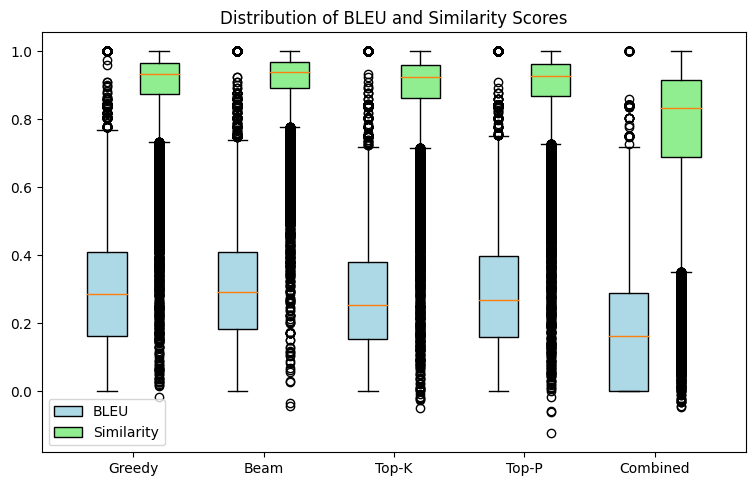

In [16]:
# Create a figure with multiple subplots
plt.figure(figsize=(20, 12))

# 1. Box Plot for both metrics
plt.subplot(2, 2, 1)
data_bleu = [
    greedy_results['bleu_score'],
    beam_results['bleu_score'],
    topk_results['bleu_score'],
    topp_results['bleu_score'],
    combined_results['bleu_score']
]
data_sim = [
    greedy_results['similarity_score'],
    beam_results['similarity_score'],
    topk_results['similarity_score'],
    topp_results['similarity_score'],
    combined_results['similarity_score']
]

labels = ['Greedy', 'Beam', 'Top-K', 'Top-P', 'Combined']
box_positions = np.arange(len(labels))
box1 = plt.boxplot(data_bleu, positions=box_positions-0.2, widths=0.3, patch_artist=True)
box2 = plt.boxplot(data_sim, positions=box_positions+0.2, widths=0.3, patch_artist=True)

# Color the boxes
for box in box1['boxes']:
    box.set(facecolor='lightblue')
for box in box2['boxes']:
    box.set(facecolor='lightgreen')

plt.xticks(box_positions, labels)
plt.title('Distribution of BLEU and Similarity Scores')
plt.legend([box1["boxes"][0], box2["boxes"][0]], ['BLEU', 'Similarity'])

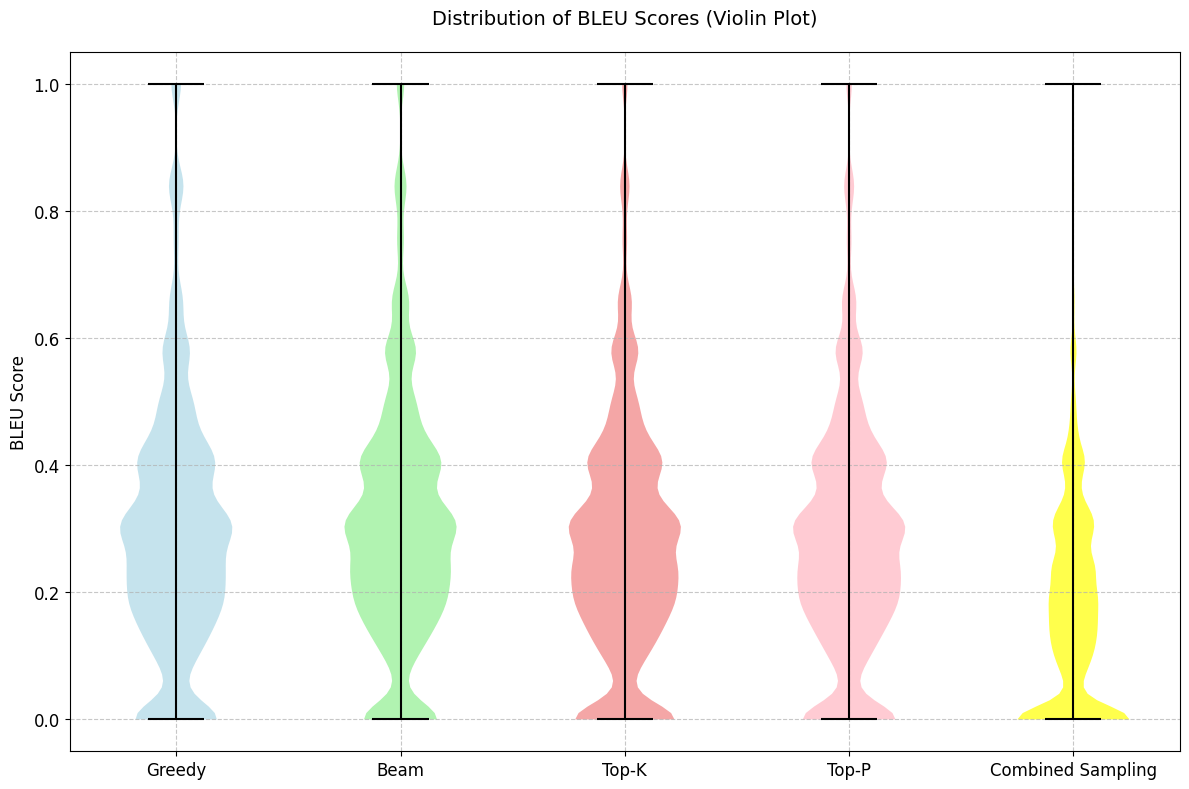

In [25]:
# 2. Violin Plot with increased size and improved styling
plt.figure(figsize=(12, 8))  # Increased figure size

violin_data = [
    greedy_results['bleu_score'],
    beam_results['bleu_score'],
    topk_results['bleu_score'],
    topp_results['bleu_score'],
    combined_results['bleu_score']
]

# Create the violin plot
violin = plt.violinplot(violin_data, positions=range(len(labels)))

# Define colors for each violin
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'yellow']

# Customize violin plot appearance
for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    
# Customize lines
violin['cbars'].set_color('black')
violin['cmins'].set_color('black')
violin['cmaxes'].set_color('black')

plt.xticks(range(len(labels)), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of BLEU Scores (Violin Plot)', fontsize=14, pad=20)
plt.ylabel('BLEU Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add padding around the plot
plt.tight_layout()
plt.show()

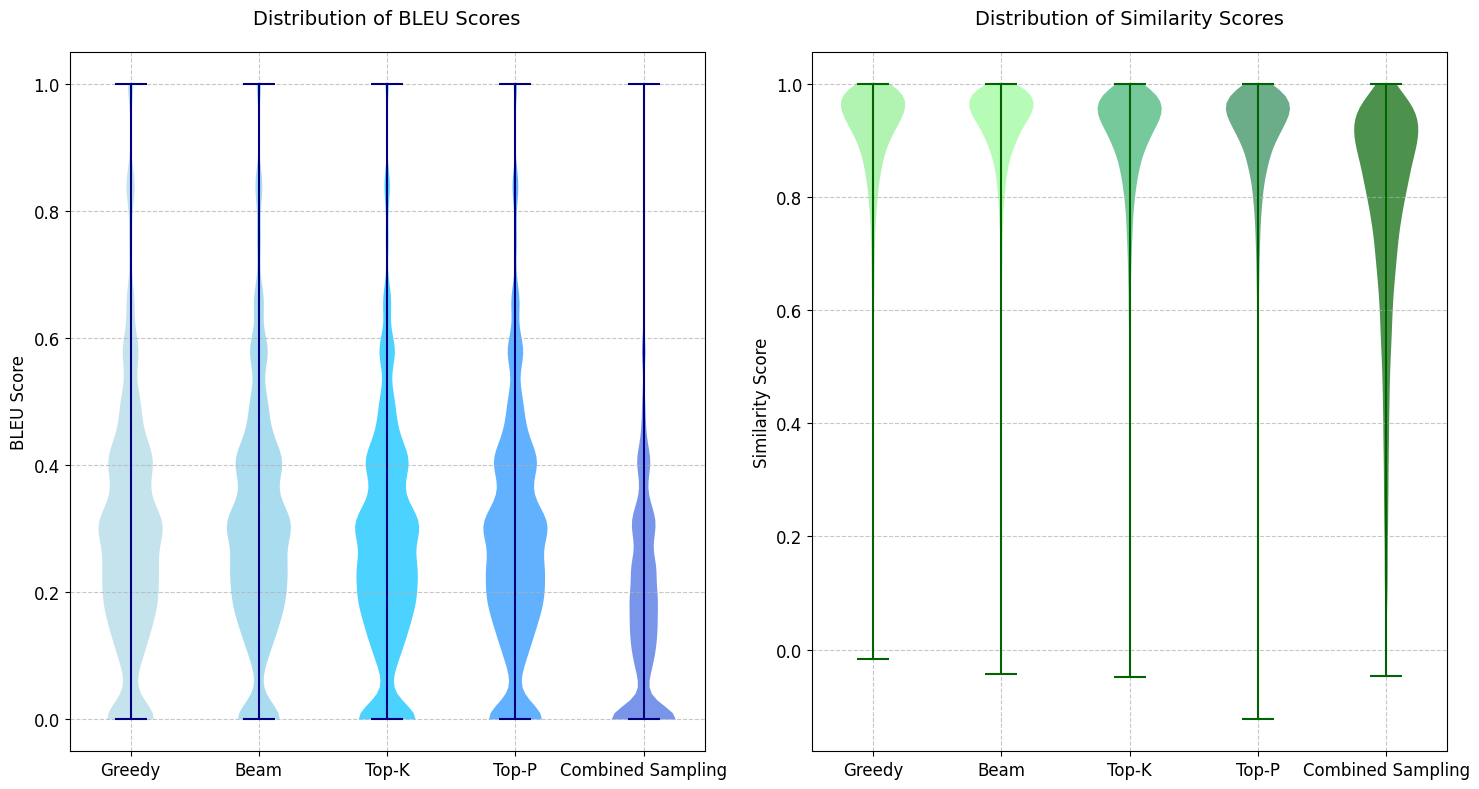

In [26]:
# Create violin plots for both BLEU and Similarity scores side by side
plt.figure(figsize=(15, 8))  # Wider figure to accommodate both plots

# First subplot for BLEU scores
plt.subplot(1, 2, 1)
violin_data_bleu = [
    greedy_results['bleu_score'],
    beam_results['bleu_score'],
    topk_results['bleu_score'],
    topp_results['bleu_score'],
    combined_results['bleu_score']
]

violin_bleu = plt.violinplot(violin_data_bleu, positions=range(len(labels)))

# Customize BLEU violin plot appearance with blue color scheme
colors_bleu = ['#ADD8E6', '#87CEEB', '#00BFFF', '#1E90FF', '#4169E1']  # Different shades of blue
for pc, color in zip(violin_bleu['bodies'], colors_bleu):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    
# Customize lines for BLEU plot
violin_bleu['cbars'].set_color('navy')
violin_bleu['cmins'].set_color('navy')
violin_bleu['cmaxes'].set_color('navy')

plt.xticks(range(len(labels)), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of BLEU Scores', fontsize=14, pad=20)
plt.ylabel('BLEU Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Second subplot for Similarity scores
plt.subplot(1, 2, 2)
violin_data_sim = [
    greedy_results['similarity_score'],
    beam_results['similarity_score'],
    topk_results['similarity_score'],
    topp_results['similarity_score'],
    combined_results['similarity_score']
]

violin_sim = plt.violinplot(violin_data_sim, positions=range(len(labels)))

# Customize Similarity violin plot appearance with green color scheme
colors_sim = ['#90EE90', '#98FB98', '#3CB371', '#2E8B57', '#006400']  # Different shades of green
for pc, color in zip(violin_sim['bodies'], colors_sim):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    
# Customize lines for Similarity plot
violin_sim['cbars'].set_color('darkgreen')
violin_sim['cmins'].set_color('darkgreen')
violin_sim['cmaxes'].set_color('darkgreen')

plt.xticks(range(len(labels)), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Similarity Scores', fontsize=14, pad=20)
plt.ylabel('Similarity Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add padding around the plots
plt.tight_layout()
plt.show()

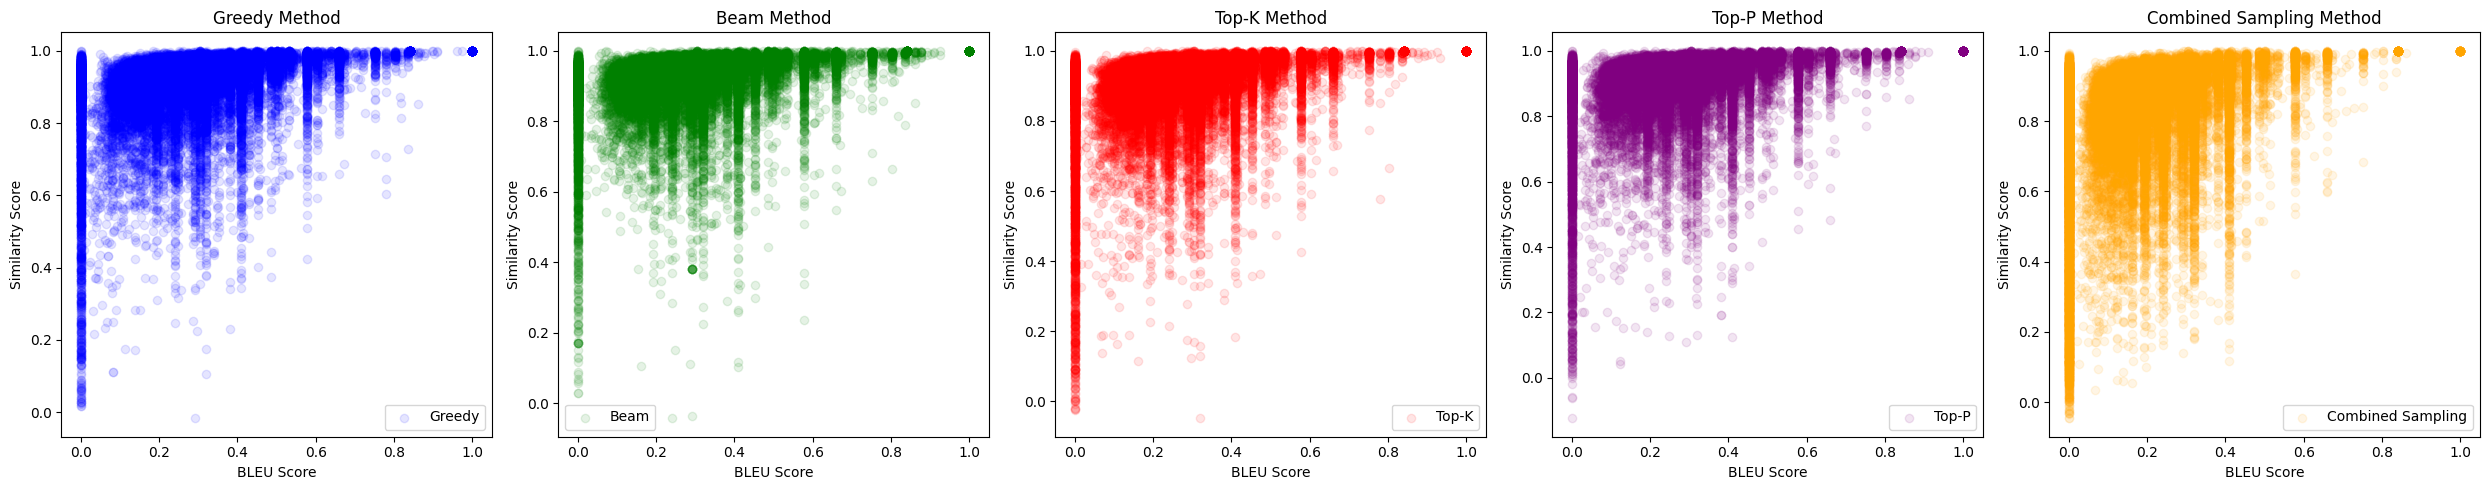

In [22]:
# Create a figure with 5 subplots, one for each method
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # Adjust figsize for larger plots

# Define colors and labels
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = ['Greedy', 'Beam', 'Top-K', 'Top-P', 'Combined Sampling']

# Iterate over each method to create individual scatter plots
for i, (df, label, color) in enumerate(zip(
    [greedy_results, beam_results, topk_results, topp_results, combined_results],
    labels, colors)):
    axes[i].scatter(df['bleu_score'], df['similarity_score'], 
                    alpha=0.1, color=color, label=label)
    axes[i].set_xlabel('BLEU Score')
    axes[i].set_ylabel('Similarity Score')
    axes[i].set_title(f'{label} Method')
    axes[i].legend()

plt.tight_layout()
plt.show()


=== Greedy Search Statistics ===

BLEU Score Statistics:
count    25000.000000
mean         0.297845
std          0.206774
min          0.000000
25%          0.163659
50%          0.285744
75%          0.408248
max          1.000000
Name: bleu_score, dtype: float64

Similarity Score Statistics:
count    25000.000000
mean         0.897701
std          0.116453
min         -0.016724
25%          0.873283
50%          0.933073
75%          0.967215
max          1.000000
Name: similarity_score, dtype: float64

Quartile Analysis:
BLEU Score IQR: 0.245
Similarity Score IQR: 0.094

Skewness and Kurtosis:
BLEU Score Skewness: 0.907
BLEU Score Kurtosis: 1.245
Similarity Score Skewness: -2.925
Similarity Score Kurtosis: 11.868
--------------------------------------------------------------------------------

=== Beam Search Statistics ===

BLEU Score Statistics:
count    25000.000000
mean         0.306174
std          0.200710
min          0.000000
25%          0.182778
50%          0.292523
75%

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

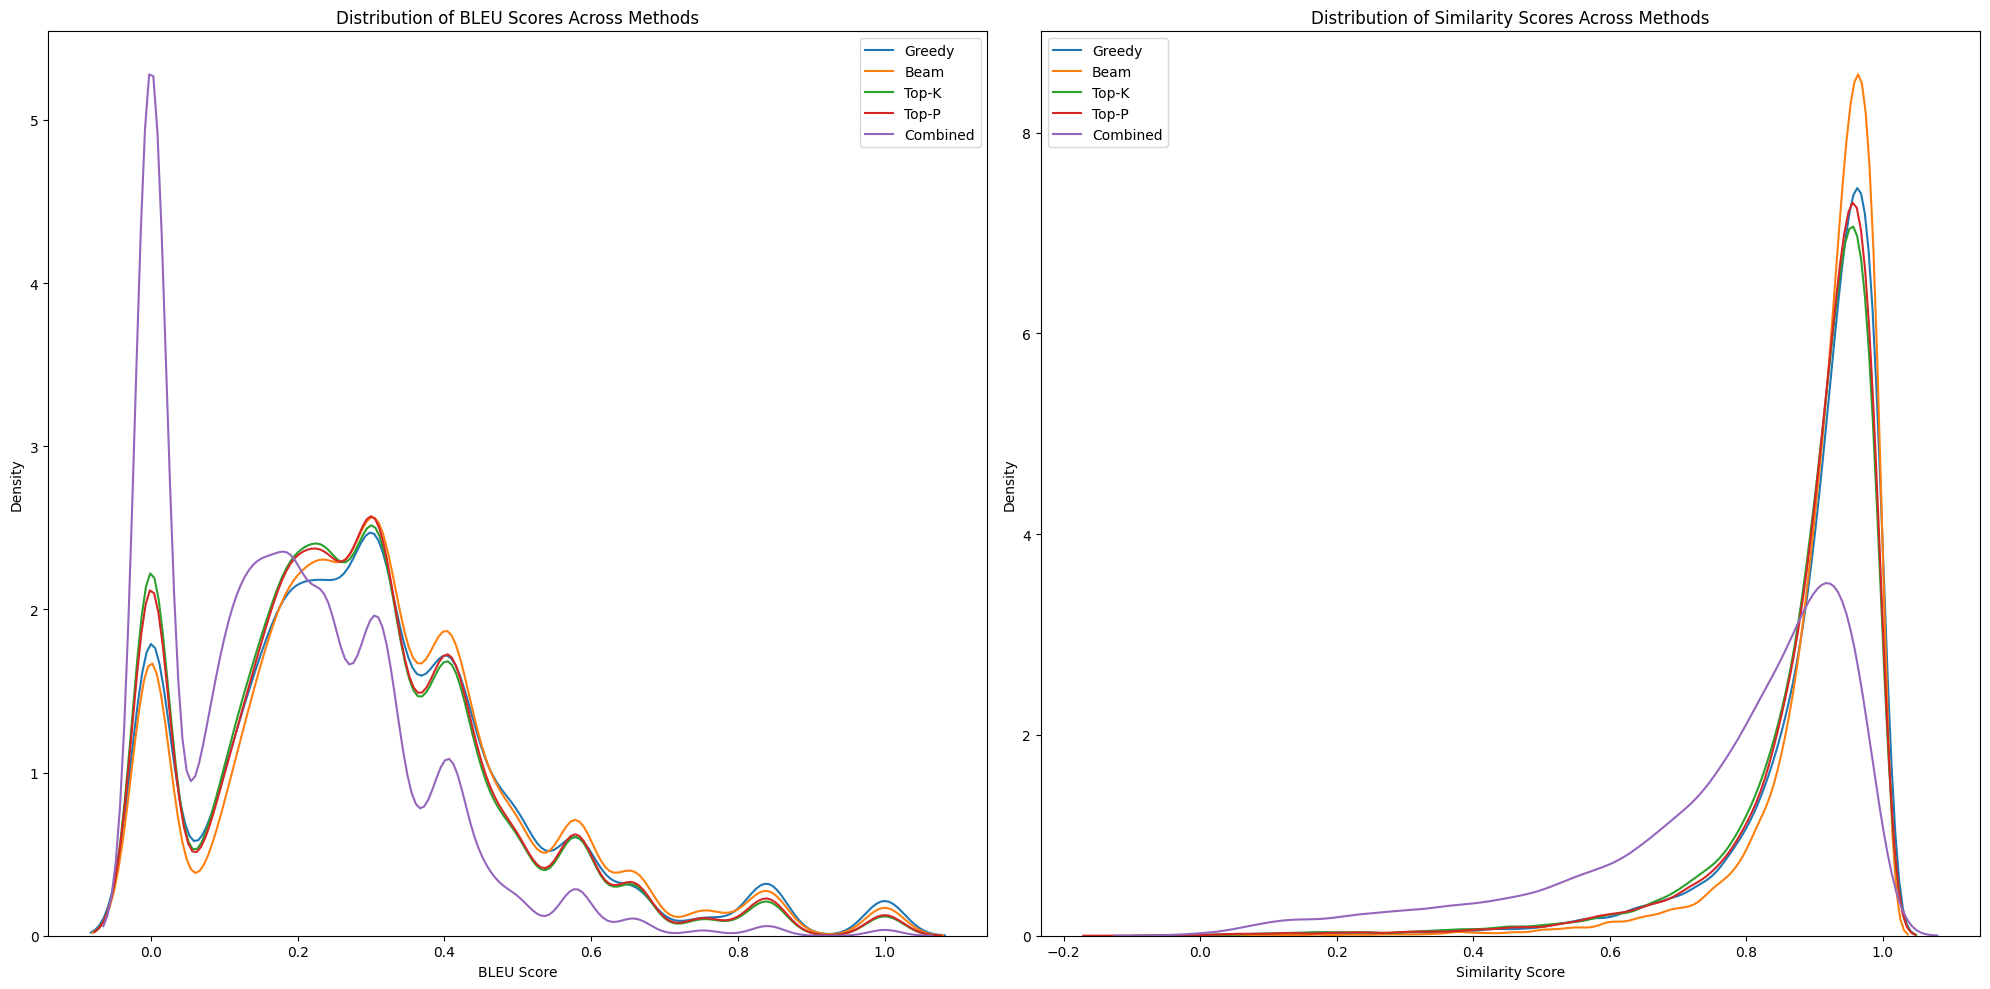

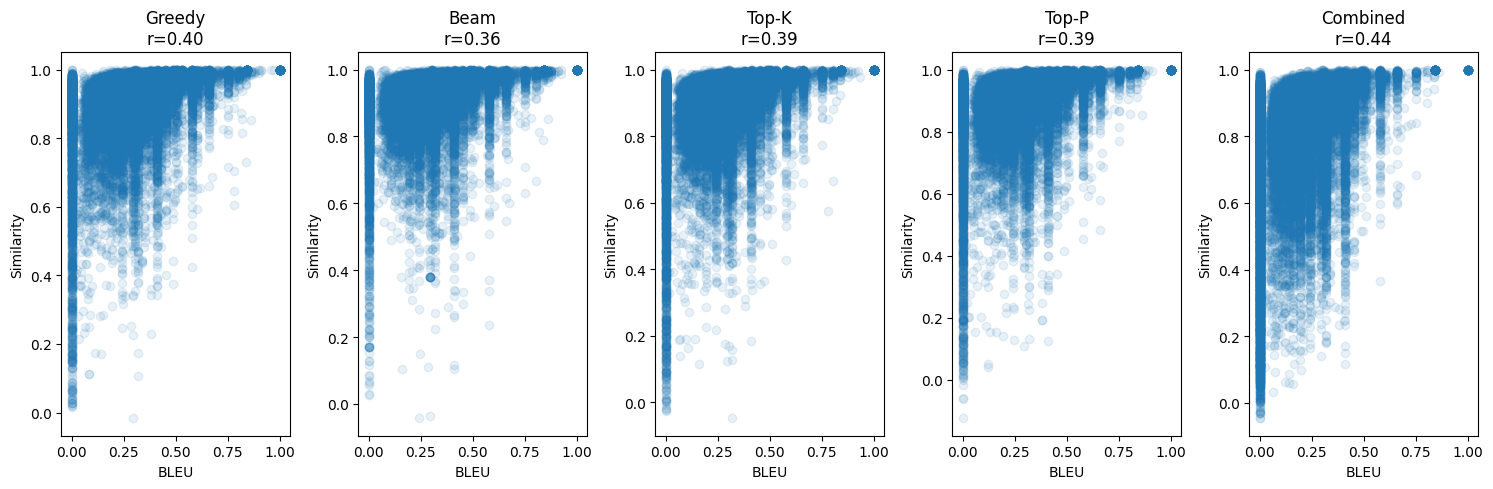

In [27]:
# Create detailed statistical analysis
methods = {
    'Greedy': greedy_results,
    'Beam': beam_results,
    'Top-K': topk_results,
    'Top-P': topp_results,
    'Combined': combined_results
}

# Detailed statistics for each method
for method_name, df in methods.items():
    print(f"\n=== {method_name} Search Statistics ===")
    
    print("\nBLEU Score Statistics:")
    print(df['bleu_score'].describe())
    
    print("\nSimilarity Score Statistics:")
    print(df['similarity_score'].describe())
    
    # Additional statistics
    print("\nQuartile Analysis:")
    print(f"BLEU Score IQR: {df['bleu_score'].quantile(0.75) - df['bleu_score'].quantile(0.25):.3f}")
    print(f"Similarity Score IQR: {df['similarity_score'].quantile(0.75) - df['similarity_score'].quantile(0.25):.3f}")
    
    print("\nSkewness and Kurtosis:")
    print(f"BLEU Score Skewness: {df['bleu_score'].skew():.3f}")
    print(f"BLEU Score Kurtosis: {df['bleu_score'].kurtosis():.3f}")
    print(f"Similarity Score Skewness: {df['similarity_score'].skew():.3f}")
    print(f"Similarity Score Kurtosis: {df['similarity_score'].kurtosis():.3f}")
    
    print("-" * 80)

# Create visualization of distributions
plt.figure(figsize=(20, 10))

# Plot BLEU score distributions
plt.subplot(1, 2, 1)
for method_name, df in methods.items():
    sns.kdeplot(data=df['bleu_score'], label=method_name)
plt.title('Distribution of BLEU Scores Across Methods')
plt.xlabel('BLEU Score')
plt.ylabel('Density')
plt.legend()

# Plot Similarity score distributions
plt.subplot(1, 2, 2)
for method_name, df in methods.items():
    sns.kdeplot(data=df['similarity_score'], label=method_name)
plt.title('Distribution of Similarity Scores Across Methods')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Create correlation analysis
plt.figure(figsize=(15, 5))
for i, (method_name, df) in enumerate(methods.items(), 1):
    plt.subplot(1, 5, i)
    plt.scatter(df['bleu_score'], df['similarity_score'], alpha=0.1)
    plt.title(f'{method_name}\nr={df["bleu_score"].corr(df["similarity_score"]):.2f}')
    plt.xlabel('BLEU')
    plt.ylabel('Similarity')

plt.tight_layout()
plt.show()

In [61]:
def show_low_similarity_examples(df, method_name, threshold=0.7, n_examples=5):
    low_sim = df[df['similarity_score'] < threshold].sort_values('similarity_score')
    
    print(f"\n=== {method_name} - Examples with Similarity Score < {threshold} ===")
    for i in range(min(n_examples, len(low_sim))):
        row = low_sim.iloc[i]
        print(f"\nExample {i+1} (Similarity: {row['similarity_score']:.3f}, BLEU: {row['bleu_score']:.3f})")
        print("Original:", row['original_kannada'])
        print("English:", row['english_translation'])
        print("Back Translation:", row['back_translation'])
        print("-" * 80)

# Show examples for each method
for method_name, df in {
    'Greedy': greedy_results,
    'Beam': beam_results,
    'Top-K': topk_results,
    'Top-P': topp_results,
    'Combined': combined_results
}.items():
    show_low_similarity_examples(df, method_name)

# Print statistics about low similarity cases
print("\nPercentage of cases with similarity < 0.7:")
for method_name, df in {
    'Greedy': greedy_results,
    'Beam': beam_results,
    'Top-K': topk_results,
    'Top-P': topp_results,
    'Combined': combined_results
}.items():
    pct = (df['similarity_score'] < 0.7).mean() * 100
    count = (df['similarity_score'] < 0.7).sum()
    print(f"{method_name}: {pct:.1f}% ({count} cases)")


=== Greedy - Examples with Similarity Score < 0.7 ===

Example 1 (Similarity: -0.017, BLEU: 0.293)
Original: ಬಾಣಲೆಗೆ ಎಣ್ಣೆ ಹಾಕಿ ಬಿಸಿಮಾಡಿ
English: I'm going to play hockey
Back Translation: ನಾನು ಹಾಕಿ ಆಡಲಿದ್ದೇನೆ
--------------------------------------------------------------------------------

Example 2 (Similarity: 0.016, BLEU: 0.000)
Original: ಬೈಕ್‍ನಿಂದ ಬಿದ್ದು ಸವಾರ ಸಾವು
English: I'm going to go to the bathroom
Back Translation: ನಾನು ಶೌಚಾಲಯಕ್ಕೆ ಹೋಗುತ್ತೇನೆ
--------------------------------------------------------------------------------

Example 3 (Similarity: 0.019, BLEU: 0.000)
Original: ಖಾಸಗೀಕರಣ ವಿರೋಧಿಸಿ ಮುಷ್ಕರ
English: The government has already announced a new government.
Back Translation: ಸರ್ಕಾರ ಈಗಾಗಲೇ ಹೊಸ ಸರ್ಕಾರವನ್ನು ಘೋಷಿಸಿದೆ.
--------------------------------------------------------------------------------

Example 4 (Similarity: 0.022, BLEU: 0.000)
Original: FSpot ಲೈವ್ ಜಾಲ ಗ್ಯಾಲರಿ
English: The following is a list of the official languages of the United States of America
Back Trans

In [54]:
def show_low_metric_examples(df, method_name, sim_threshold=0.7, bleu_threshold=0.1, n_examples=5):
    # Filter for both low similarity and low BLEU
    low_metrics = df[
        (df['similarity_score'] < sim_threshold) & 
        (df['bleu_score'] < bleu_threshold)
    ].sort_values('similarity_score')
    
    print(f"\n=== {method_name} - Examples with Similarity < {sim_threshold} and BLEU < {bleu_threshold} ===")
    for i in range(min(n_examples, len(low_metrics))):
        row = low_metrics.iloc[i]
        print(f"\nExample {i+1}")
        print(f"Metrics: Similarity: {row['similarity_score']:.3f}, BLEU: {row['bleu_score']:.3f}")
        print("Original:", row['original_kannada'])
        print("English:", row['english_translation'])
        print("Back Translation:", row['back_translation'])
        print("-" * 80)
    
    # Calculate statistics for this method
    total_cases = len(low_metrics)
    percentage = (total_cases / len(df)) * 100
    return total_cases, percentage

# Show examples and collect statistics for each method
print("Analysis of Low-Quality Translations (Similarity < 0.7 AND BLEU < 0.5):")
stats = {}
for method_name, df in {
    'Greedy': greedy_results,
    'Beam': beam_results,
    'Top-K': topk_results,
    'Top-P': topp_results,
    'Combined': combined_results
}.items():
    cases, pct = show_low_metric_examples(df, method_name)
    stats[method_name] = {'cases': cases, 'percentage': pct}

# Print summary statistics
print("\nSummary of Low-Quality Translations:")
print("\nMethod     Cases    Percentage")
print("-" * 30)
for method, values in stats.items():
    print(f"{method:<10} {values['cases']:<8} {values['percentage']:.1f}%")

Analysis of Low-Quality Translations (Similarity < 0.7 AND BLEU < 0.5):

=== Greedy - Examples with Similarity < 0.7 and BLEU < 0.1 ===

Example 1
Metrics: Similarity: 0.016, BLEU: 0.000
Original: ಬೈಕ್‍ನಿಂದ ಬಿದ್ದು ಸವಾರ ಸಾವು
English: I'm going to go to the bathroom
Back Translation: ನಾನು ಶೌಚಾಲಯಕ್ಕೆ ಹೋಗುತ್ತೇನೆ
--------------------------------------------------------------------------------

Example 2
Metrics: Similarity: 0.019, BLEU: 0.000
Original: ಖಾಸಗೀಕರಣ ವಿರೋಧಿಸಿ ಮುಷ್ಕರ
English: The government has already announced a new government.
Back Translation: ಸರ್ಕಾರ ಈಗಾಗಲೇ ಹೊಸ ಸರ್ಕಾರವನ್ನು ಘೋಷಿಸಿದೆ.
--------------------------------------------------------------------------------

Example 3
Metrics: Similarity: 0.022, BLEU: 0.000
Original: FSpot ಲೈವ್ ಜಾಲ ಗ್ಯಾಲರಿ
English: The following is a list of the official languages of the United States of America
Back Translation: ಅಮೆರಿಕ ಸಂಯುಕ್ತ ಸಂಸ್ಥಾನದ ಅಧಿಕೃತ ಭಾಷೆಗಳ ಪಟ್ಟಿ
--------------------------------------------------------------------------------

E

In [68]:
# Load and clean the DataFrames
greedy_results = pd.read_csv('greedy_25k.csv')
beam_results = pd.read_csv('beam25k.csv')
topk_results = pd.read_csv('topk25k.csv')
topp_results = pd.read_csv('topP_25k.csv')
combined_results = pd.read_csv('combined_25k.csv')

# Remove rows with null values and save with the same filenames
greedy_results.dropna(inplace=True)
greedy_results.to_csv('greedy_25k.csv', index=False)

beam_results.dropna(inplace=True)
beam_results.to_csv('beam25k.csv', index=False)

topk_results.dropna(inplace=True)
topk_results.to_csv('topk25k.csv', index=False)

topp_results.dropna(inplace=True)
topp_results.to_csv('topP_25k.csv', index=False)

combined_results.dropna(inplace=True)
combined_results.to_csv('combined_25k.csv', index=False)

In [70]:
greedy_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24996 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   original_kannada     24996 non-null  object 
 1   english_translation  24996 non-null  object 
 2   back_translation     24996 non-null  object 
 3   similarity_score     24996 non-null  float64
 4   bleu_score           24996 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.1+ MB


In [71]:
# Filter rows where similarity_score > 0.7 and reset indices
greedy_results = greedy_results[greedy_results['similarity_score'] > 0.7].reset_index(drop=True)
beam_results = beam_results[beam_results['similarity_score'] > 0.7].reset_index(drop=True)
topk_results = topk_results[topk_results['similarity_score'] > 0.7].reset_index(drop=True)
topp_results = topp_results[topp_results['similarity_score'] > 0.7].reset_index(drop=True)
combined_results = combined_results[combined_results['similarity_score'] > 0.7].reset_index(drop=True)

# Print the number of rows in each DataFrame
print(f"Rows in greedy results: {len(greedy_results)}")
print(f"Rows in beam results: {len(beam_results)}")
print(f"Rows in top-k results: {len(topk_results)}")
print(f"Rows in top-p results: {len(topp_results)}")
print(f"Rows in combined results: {len(combined_results)}")

Rows in greedy results: 23489
Rows in beam results: 24111
Rows in top-k results: 23349
Rows in top-p results: 23424
Rows in combined results: 18430


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23424 entries, 0 to 23423
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   original          23424 non-null  object 
 1   english           23424 non-null  object 
 2   back_translation  23424 non-null  object 
 3   similarity_score  23424 non-null  float64
 4   bleu_score        23424 non-null  float64
dtypes: float64(2), object(3)
memory usage: 915.1+ KB


In [81]:
# Create new DataFrame with original sentences
new_df = pd.DataFrame({
    'original': sentence_similarity['Kannada'].iloc[:25000]
})

# Dictionary of method names and their corresponding DataFrames
method_dfs = {
    'greedy': greedy_results,
    'beam': beam_results,
    'topk': topk_results,
    'topp': topp_results,
    'combined': combined_results
}

# For each method, add paraphrase and metrics if original matches
for method_name, df in method_dfs.items():
    # Initialize new columns with None/NaN
    new_df[f'{method_name}_paraphrase'] = None
    new_df[f'{method_name}_bleu'] = None
    new_df[f'{method_name}_similarity'] = None
    
    # Get the appropriate column name for original text in each method's DataFrame
    original_col = 'original_kannada' if 'original_kannada' in df.columns else 'original'
    
    # Match and fill data
    for idx, row in new_df.iterrows():
        # Find matching row in method's DataFrame
        match = df[df[original_col] == row['original']]
        if not match.empty:
            new_df.at[idx, f'{method_name}_paraphrase'] = match.iloc[0]['back_translation']
            new_df.at[idx, f'{method_name}_bleu'] = match.iloc[0]['bleu_score']
            new_df.at[idx, f'{method_name}_similarity'] = match.iloc[0]['similarity_score']


In [14]:
reduced_df=pd.read_csv('reduced25k.csv')

In [15]:
# Display summary
print("\nDataFrame Info:")
print(reduced_df.info())
print("\nSample rows:")
print(reduced_df.head())

# Display statistics about matches
#for method in method_dfs.keys():
    #match_count = reduced_df[f'{method}_paraphrase'].notna().sum()
    #print(f"\n{method.capitalize()} matches: {match_count} ({(match_count/len(reduced_df))*100:.2f}%)")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           25000 non-null  int64  
 1   original             25000 non-null  object 
 2   greedy_paraphrase    23489 non-null  object 
 3   greedy_bleu          23489 non-null  float64
 4   greedy_similarity    23489 non-null  float64
 5   beam_paraphrase      24111 non-null  object 
 6   beam_bleu            24111 non-null  float64
 7   beam_similarity      24111 non-null  float64
 8   topk_paraphrase      23363 non-null  object 
 9   topk_bleu            23363 non-null  float64
 10  topk_similarity      23363 non-null  float64
 11  topp_paraphrase      23435 non-null  object 
 12  topp_bleu            23435 non-null  float64
 13  topp_similarity      23435 non-null  float64
 14  combined_paraphrase  18456 non-null  object 
 15  combined_bleu      

In [16]:
reduced_df.head()

,Unnamed: 0,original,greedy_paraphrase,greedy_bleu,greedy_similarity,beam_paraphrase,beam_bleu,beam_similarity,topk_paraphrase,topk_bleu,topk_similarity,topp_paraphrase,topp_bleu,topp_similarity,combined_paraphrase,combined_bleu,combined_similarity
0,0,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳು,0.351863,0.923566,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಬಹಳಷ್ಟು ವಿಡಿಯೋಗಳಿವೆ.,0.351863,0.933064,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಹಲವು ವಿಡಿಯೋಗಳಿವೆ.,0.351863,0.902236,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳಿವೆ.,0.351863,0.899628,ಸಾಮಾಜಿಕ ಮಾಧ್ಯಮಗಳಲ್ಲಿ ಹಲವು ವೀಡಿಯೋಗಳನ್ನು ಆರ್ಭಟಿಸ...,0.240281,0.920732
1,1,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದು ತಿಳಿಸಿ...,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿಯನ್ನು ನಿಯಂತ್ರಣದಲ್ಲಿಟ್ಟುಕೊಂಡಿ...,0.248805,0.936831,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದು ಅವರು ಹ...,0.604275,0.965995,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದು ಅವರು ಹ...,0.604275,0.965995,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿದೆ ಎಂದರು.,0.512480,0.982864,ಪ್ರಸ್ತುತ ಪರಿಸ್ಥಿತಿ ನಿಯಂತ್ರಣದಲ್ಲಿರುವಂತೆ ಹೇಳಿಕೊಂ...,0.351863,0.881914
2,2,ಕೈಲಾಶ್ ಚೌಧರಿ ಕೃಷಿ ಮತ್ತು ರೈತರ ಕಲ್ಯಾಣ ಸಹಾಯ ಸಚಿವರು,ಕೃಷಿ ಮತ್ತು ರೈತರ ಕಲ್ಯಾಣ ಸಚಿವ,0.412773,0.786515,ಕೈಲಾಶ್ ಚೌಧ್ರಿ ಕೃಷಿ ಮತ್ತು ರೈತರ ಕಲ್ಯಾಣ ಸಚಿವ,0.463366,0.908330,ಕೃಷಿ ಮತ್ತು ರೈತರ ಕಲ್ಯಾಣ ಸಚಿವ,0.412773,0.786515,ಕೃಷಿ ಮತ್ತು ಗ್ರಾಮೀಣ ವ್ಯವಹಾರಗಳ ಸಚಿವ,0.186491,0.728154,ಕೈಲಾಷ್ ಚೌಧ್ರಿಯ ಕೃಷಿ ಮತ್ತು ರೈತರ ಕಲ್ಯಾಣ,0.432982,0.831533
3,3,ನಿರ್ದಿಷ್ಟಗೊಳಿಸಲಾದ ಬ್ಯಾಂಕ್ ನೋಟುಗಳ ಠೇವಣಿಯ ಕುರಿತು...,ಸಾರ್ವಜನಿಕ ಖಾಸಗಿ ಗ್ರಾಮೀಣ ಮತ್ತು ಸಹಕಾರಿ ಬ್ಯಾಂಕ್ ಗ...,0.167528,0.970141,ಸಾರ್ವಜನಿಕ-ಖಾಸಗಿ ಗ್ರಾಮೀಣ ಮತ್ತು ಸಹಕಾರಿ ಬ್ಯಾಂಕುಗಳ...,0.109475,0.956844,ಸಾರ್ವಜನಿಕ-ಖಾಸಗಿ ಗ್ರಾಮೀಣ ಮತ್ತು ಸಹಕಾರಿ ಬ್ಯಾಂಕುಗಳ...,0.144078,0.955930,ಸಾರ್ವಜನಿಕ ಖಾಸಗಿ ಗ್ರಾಮೀಣ ಮತ್ತು ಸಹಕಾರಿ ಬ್ಯಾಂಕುಗಳ...,0.139644,0.939877,"ಕೇಂದ್ರ ಸರ್ಕಾರ, ಖಾಸಗಿ ಮತ್ತು ಸಹಕಾರ ಬ್ಯಾಂಕ್ಗಳನ್ನು...",0.058776,0.772127
4,4,ಅರ್ಥ ಮಾಡಿಕೊಳ್ಳಬೇಕು ಅನ್ನಿಸಿದೆಯಾ?,ನೀವು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಭಾವಿಸುತ್ತೀರಾ?,0.000000,0.938417,ನಾವು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಭಾವಿಸುತ್ತೀರಾ?,0.000000,0.887910,NaN,NaN,NaN,ನಾನು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಯೋಚಿಸುತ್ತೀರಾ?,0.000000,0.838628,ನೀವು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕೇ?,0.000000,0.928260


In [17]:
def find_high_bleu_outliers(df, threshold=0.95):
    methods = ['greedy', 'beam', 'topk', 'topp', 'combined']
    
    print(f"\nCount of sentences with BLEU score >= {threshold}:")
    print("-" * 50)
    
    for method in methods:
        high_bleu = df[df[f'{method}_bleu'] >= threshold]
        count = len(high_bleu)
        percentage = (count / len(df)) * 100
        
        print(f"{method.capitalize()}: {count} sentences ({percentage:.2f}%)")
        
        # Original detailed output
        print(f"\n=== {method.capitalize()} Method - High BLEU Score Outliers (>= {threshold}) ===")
        for idx, row in high_bleu.iterrows():
            print(f"\nIndex: {idx}")
            print("Original Kannada:", row['original'])
            print(f"{method.capitalize()} Paraphrase:", row[f'{method}_paraphrase'])
            print(f"BLEU Score: {row[f'{method}_bleu']:.3f}")
            print(f"Similarity Score: {row[f'{method}_similarity']:.3f}")
            print("-" * 80)

# Call the function with the reduced_df
find_high_bleu_outliers(reduced_df, threshold=0.8)


Count of sentences with BLEU score >= 0.8:
--------------------------------------------------
Greedy: 951 sentences (3.80%)

=== Greedy Method - High BLEU Score Outliers (>= 0.8) ===

Index: 23
Original Kannada: ಬಿಹಾರ ಹಿಂದುಳಿದ ರಾಜ್ಯ
Greedy Paraphrase: ಬಿಹಾರ ಹಿಂದುಳಿದ ರಾಜ್ಯ
BLEU Score: 0.841
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 29
Original Kannada: ನಿಮ್ಮ ದೀರ್ಘ ಮತ್ತು ಆರೋಗ್ಯಕರ ಜೀವನಕ್ಕಾಗಿ ನಾನು ಪ್ರಾರ್ಥಿಸುತ್ತೇನೆ
Greedy Paraphrase: ನಿಮ್ಮ ದೀರ್ಘ ಮತ್ತು ಆರೋಗ್ಯಕರ ಜೀವನಕ್ಕಾಗಿ ನಾನು ಪ್ರಾರ್ಥಿಸುತ್ತೇನೆ
BLEU Score: 1.000
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 85
Original Kannada: ಭಾರತವು ತನ್ನದೇ ಆದ ಸಂಸ್ಕೃತಿ ಮತ್ತು ಸಂಪ್ರದಾಯಗಳಿಗೆ ಹೆಸರುವಾಸಿಯಾಗಿದೆ
Greedy Paraphrase: ಭಾರತವು ತನ್ನದೇ ಆದ ಸಂಸ್ಕೃತಿ ಮತ್ತು ಸಂಪ್ರದಾಯಗಳಿಗೆ ಹೆಸರುವಾಸಿಯಾಗಿದೆ
BLEU Score: 1.000
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 105
Origi

In [18]:
def remove_high_bleu_outputs(df, threshold=0.95):
    methods = ['greedy', 'beam', 'topk', 'topp', 'combined']
    filtered_df = df.copy()
    removal_stats = {}
    
    for method in methods:
        # Count original non-null values
        original_count = filtered_df[f'{method}_paraphrase'].notna().sum()
        
        # Create mask for high BLEU scores
        high_bleu_mask = filtered_df[f'{method}_bleu'] >= threshold
        
        # Set values to None/NaN where BLEU is too high
        columns_to_clear = [
            f'{method}_paraphrase',
            f'{method}_bleu',
            f'{method}_similarity'
        ]
        
        for col in columns_to_clear:
            if col in filtered_df.columns:
                filtered_df.loc[high_bleu_mask, col] = None
        
        # Count removals
        removed_count = high_bleu_mask.sum()
        removal_stats[method] = {
            'original_count': original_count,
            'removed_count': removed_count,
            'remaining_count': original_count - removed_count
        }
    
    # Print statistics
    print("\nRemoval Statistics by Method:")
    print("-" * 60)
    for method, stats in removal_stats.items():
        print(f"\n{method.capitalize()}:")
        print(f"Original outputs: {stats['original_count']}")
        print(f"Removed outputs: {stats['removed_count']}")
        print(f"Remaining outputs: {stats['remaining_count']}")
        print(f"Removal percentage: {(stats['removed_count']/stats['original_count']*100):.2f}%")
    
    # Print example of partial removals
    print("\nExample of partial removals (first 3 rows with any removal):")
    example_rows = filtered_df[filtered_df[[f'{m}_paraphrase' for m in methods]].isna().any(axis=1)].head(3)
    for idx, row in example_rows.iterrows():
        print(f"\nIndex: {idx}")
        print("Original:", row['original'])
        for method in methods:
            if pd.isna(row[f'{method}_paraphrase']):
                print(f"{method.capitalize()}: REMOVED (original BLEU was too high)")
            else:
                print(f"{method.capitalize()} (BLEU: {row[f'{method}_bleu']:.3f}):", 
                      row[f'{method}_paraphrase'])
        print("-" * 80)
    
    return filtered_df

# Apply the function to your DataFrame
filtered_df = remove_high_bleu_outputs(reduced_df, threshold=0.85)

# Save the filtered DataFrame


Removal Statistics by Method:
------------------------------------------------------------

Greedy:
Original outputs: 23489
Removed outputs: 382
Remaining outputs: 23107
Removal percentage: 1.63%

Beam:
Original outputs: 24111
Removed outputs: 324
Remaining outputs: 23787
Removal percentage: 1.34%

Topk:
Original outputs: 23363
Removed outputs: 201
Remaining outputs: 23162
Removal percentage: 0.86%

Topp:
Original outputs: 23435
Removed outputs: 213
Remaining outputs: 23222
Removal percentage: 0.91%

Combined:
Original outputs: 18456
Removed outputs: 49
Remaining outputs: 18407
Removal percentage: 0.27%

Example of partial removals (first 3 rows with any removal):

Index: 4
Original: ಅರ್ಥ ಮಾಡಿಕೊಳ್ಳಬೇಕು ಅನ್ನಿಸಿದೆಯಾ?
Greedy (BLEU: 0.000): ನೀವು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಭಾವಿಸುತ್ತೀರಾ?
Beam (BLEU: 0.000): ನಾವು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಭಾವಿಸುತ್ತೀರಾ?
Topk: REMOVED (original BLEU was too high)
Topp (BLEU: 0.000): ನಾನು ಅರ್ಥಮಾಡಿಕೊಳ್ಳಬೇಕು ಎಂದು ನೀವು ಯೋಚಿಸುತ್ತೀರಾ?
Combined (BLEU: 0.000): ನೀವು

In [19]:
filtered_df.head()
filtered_df.info()
# Save the filtered DataFrame
#filtered_df.to_csv('reduced25k_filtered.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           25000 non-null  int64  
 1   original             25000 non-null  object 
 2   greedy_paraphrase    23107 non-null  object 
 3   greedy_bleu          23107 non-null  float64
 4   greedy_similarity    23107 non-null  float64
 5   beam_paraphrase      23787 non-null  object 
 6   beam_bleu            23787 non-null  float64
 7   beam_similarity      23787 non-null  float64
 8   topk_paraphrase      23162 non-null  object 
 9   topk_bleu            23162 non-null  float64
 10  topk_similarity      23162 non-null  float64
 11  topp_paraphrase      23222 non-null  object 
 12  topp_bleu            23222 non-null  float64
 13  topp_similarity      23222 non-null  float64
 14  combined_paraphrase  18407 non-null  object 
 15  combined_bleu        18407 non-null 

In [20]:
def find_perfect_similarity(df):
    methods = ['greedy', 'beam', 'topk', 'topp', 'combined']
    
    for method in methods:
        perfect_similarity = df[df[f'{method}_similarity'] == 1.00]
        count = len(perfect_similarity)
        
        print(f"\n=== {method.capitalize()} Method - Perfect Similarity Score (1.00) ===")
        print(f"Total number of sentences with perfect similarity: {count}")
        print(f"Percentage of total dataset: {(count/len(df))*100:.2f}%")
        
        for idx, row in perfect_similarity.iterrows():
            print(f"\nIndex: {idx}")
            print("Original Kannada:", row['original'])
            print(f"{method.capitalize()} Paraphrase:", row[f'{method}_paraphrase'])
            print(f"BLEU Score: {row[f'{method}_bleu']:.3f}")
            print(f"Similarity Score: {row[f'{method}_similarity']:.3f}")
            print("-" * 80)

# Call the function with the reduced_df
find_perfect_similarity(reduced_df)


=== Greedy Method - Perfect Similarity Score (1.00) ===
Total number of sentences with perfect similarity: 463
Percentage of total dataset: 1.85%

Index: 23
Original Kannada: ಬಿಹಾರ ಹಿಂದುಳಿದ ರಾಜ್ಯ
Greedy Paraphrase: ಬಿಹಾರ ಹಿಂದುಳಿದ ರಾಜ್ಯ
BLEU Score: 0.841
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 85
Original Kannada: ಭಾರತವು ತನ್ನದೇ ಆದ ಸಂಸ್ಕೃತಿ ಮತ್ತು ಸಂಪ್ರದಾಯಗಳಿಗೆ ಹೆಸರುವಾಸಿಯಾಗಿದೆ
Greedy Paraphrase: ಭಾರತವು ತನ್ನದೇ ಆದ ಸಂಸ್ಕೃತಿ ಮತ್ತು ಸಂಪ್ರದಾಯಗಳಿಗೆ ಹೆಸರುವಾಸಿಯಾಗಿದೆ
BLEU Score: 1.000
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 116
Original Kannada: ನಾನು ನಿನ್ನನ್ನು ಪ್ರೀತಿಸುತ್ತೇನೆ
Greedy Paraphrase: ನಾನು ನಿನ್ನನ್ನು ಪ್ರೀತಿಸುತ್ತೇನೆ
BLEU Score: 0.841
Similarity Score: 1.000
--------------------------------------------------------------------------------

Index: 129
Original Kannada: ಕುಟುಂಬ ಪತ್ನಿ ಮತ್ತು ಮಕ್ಕಳು
Greedy Paraphrase: ಕುಟುಂಬ ಪತ್ನಿ ಮತ್ತು ಮಕ್ಕಳು
BLEU Score: 

In [21]:
def remove_perfect_similarity(df):
    methods = ['greedy', 'beam', 'topk', 'topp', 'combined']
    
    for method in methods:
        # Find indices where similarity is 1.00
        perfect_similarity_indices = df[df[f'{method}_similarity'] == 1.00].index
        
        # Set the corresponding cells to None or NaN
        for idx in perfect_similarity_indices:
            df.at[idx, f'{method}_paraphrase'] = None
            df.at[idx, f'{method}_bleu'] = np.nan
            df.at[idx, f'{method}_similarity'] = np.nan
    
    # Verify no perfect similarity pairs are left
    for method in methods:
        remaining_perfect = df[df[f'{method}_similarity'] == 1.00]
        if not remaining_perfect.empty:
            print(f"Warning: There are still {len(remaining_perfect)} perfect similarity pairs left for {method}.")
        else:
            print(f"All perfect similarity pairs removed for {method}.")

# Apply the function to the reduced_df
remove_perfect_similarity(filtered_df)


All perfect similarity pairs removed for greedy.
All perfect similarity pairs removed for beam.
All perfect similarity pairs removed for topk.
All perfect similarity pairs removed for topp.
All perfect similarity pairs removed for combined.


In [22]:
# Save the updated DataFrame
filtered_df.to_csv('reduced25k.csv', index=False)

In [23]:
# Create parallel paraphrase dataset from filtered results
def create_parallel_dataset(filtered_df):
    parallel_data = {
        'original': [],
        'paraphrase': []
    }
    
    methods = ['greedy', 'beam', 'topk', 'topp', 'combined']
    
    # Iterate through each row
    for _, row in filtered_df.iterrows():
        original = row['original']
        
        # Add valid paraphrases from each method
        for method in methods:
            paraphrase = row[f'{method}_paraphrase']
            if pd.notna(paraphrase):  # Only add if paraphrase exists (not NaN)
                parallel_data['original'].append(original)
                parallel_data['paraphrase'].append(paraphrase)
    
    # Create DataFrame
    parallel_df = pd.DataFrame(parallel_data)
    
    # Remove duplicates if any
    parallel_df = parallel_df.drop_duplicates()
    
    # Print statistics
    print("\nParallel Dataset Statistics:")
    print(f"Total pairs: {len(parallel_df)}")
    print(f"Unique original sentences: {parallel_df['original'].nunique()}")
    print(f"Unique paraphrases: {parallel_df['paraphrase'].nunique()}")
    
    return parallel_df

# Create and save parallel dataset
parallel_dataset = create_parallel_dataset(filtered_df)
parallel_dataset.to_csv('kannada_paraphrase_pairs.csv', index=False)

# Display first few examples
print("\nSample pairs:")
parallel_dataset.head()


Parallel Dataset Statistics:
Total pairs: 95340
Unique original sentences: 24583
Unique paraphrases: 93876

Sample pairs:


,original,paraphrase
0,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳು
1,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಬಹಳಷ್ಟು ವಿಡಿಯೋಗಳಿವೆ.
2,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಹಲವು ವಿಡಿಯೋಗಳಿವೆ.
3,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅನೇಕ ವೀಡಿಯೊಗಳಿವೆ.
4,ಸಾಮಾಜಿಕ ಜಾಲತಾಣಗಳಲ್ಲಿ ಅದೆಷ್ಟೊ ವಿಡಿಯೋಗಳು ಹರಿದಾಡು...,ಸಾಮಾಜಿಕ ಮಾಧ್ಯಮಗಳಲ್ಲಿ ಹಲವು ವೀಡಿಯೋಗಳನ್ನು ಆರ್ಭಟಿಸ...


In [7]:
parallel_dataset = pd.read_csv('kannada_paraphrase_pairs.csv')
parallel_dataset = parallel_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
# Add periods to original sentences if missing
def add_period(text):
    text = text.strip()  # Remove any trailing whitespace
    if not text.endswith('.'):
        return text + '.'
    return text

# Show some examples before and after the change
print("Before and After Examples:")
print("-" * 80)
for i in range(5):  # Show first 5 examples
    orig = parallel_dataset['original'][i]
    modified = add_period(orig)
    if orig != modified:
        print(f"\nRow {i}:")
        print(f"Original: {orig}")
        print(f"Modified: {modified}")

# Apply the change to all rows
parallel_dataset['original'] = parallel_dataset['original'].apply(add_period)

# Model Training

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, MT5ForConditionalGeneration

# Initialize model and tokenizer using Auto classes
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
model.to(device)  

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [9]:
print(tokenizer.encode("ಹುಡುಗಾರಿಗೆ ಹೆಸರು ಇಲ್ಲಿ ಇರುವುದು ನನಗೆ ಅನಿಸಿದ್ದಾರೆ"))

# decode the tokenized text
print(tokenizer.decode(tokenizer.encode("ಹುಡುಗಾರಿಗೆ ಹೆಸರು ಇಲ್ಲಿ ಇರುವುದು ನನಗೆ ಅನಿಸಿದ್ದಾರೆ")))


[139955, 44657, 19639, 71603, 1327, 5567, 25914, 44316, 33519, 86456, 4218, 64529, 91706, 1]
ಹುಡುಗಾರಿಗೆ ಹೆಸರು ಇಲ್ಲಿ ಇರುವುದು ನನಗೆ ಅನಿಸಿದ್ದಾರೆ</s>


In [10]:
from datasets import Dataset

# convert parallel dataset to huggingface dataset
parallel_dataset = Dataset.from_pandas(parallel_dataset[['original','paraphrase']])

# check the dataset structure
print(parallel_dataset)
print(parallel_dataset[9:10])

Dataset({
    features: ['original', 'paraphrase'],
    num_rows: 95340
})
{'original': ['ವೆಸ್ಟ್ ಇಂಡೀಸ್ ವಿರುದ್ಧದ ಮೊದಲ ಟಿ ಪಂದ್ಯಕ್ಕೆ ಭಾರತ ಸಂಭಾವ್ಯ XI'], 'paraphrase': ['ವೆಸ್ಟ್ ಇಂಡೀಸ್ ವಿರುದ್ಧ ಭಾರತದ ಮೊದಲ ಟಿ-ಕ್ಲಾಸ್ ಪಂದ್ಯ']}


In [11]:
max_orig_length = 0
max_para_length = 0

# Process in batches for efficiency
for batch in parallel_dataset.select(range(len(parallel_dataset))):
    # Tokenize original sentence
    orig_tokens = tokenizer.encode(batch['original'])
    max_orig_length = max(max_orig_length, len(orig_tokens))
    
    # Tokenize paraphrase
    para_tokens = tokenizer.encode(batch['paraphrase'])
    max_para_length = max(max_para_length, len(para_tokens))

print(f"Maximum token length for original sentences: {max_orig_length}")
print(f"Maximum token length for paraphrases: {max_para_length}")
print(f"Overall maximum token length: {max(max_orig_length, max_para_length)}")

Maximum token length for original sentences: 185
Maximum token length for paraphrases: 198
Overall maximum token length: 198


In [12]:
def preprocess_function(examples):
    # Tokenize inputs directly without prefix
    model_inputs = tokenizer(
        examples["original"],
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).convert_to_tensors("pt")  # Ensure PyTorch tensors
    
    # Tokenize targets
    labels = tokenizer(
        examples["paraphrase"],
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).convert_to_tensors("pt")  # Ensure PyTorch tensors
    
    # Convert to int64 to match expected dtype
    model_inputs["input_ids"] = model_inputs["input_ids"].to(torch.int64)
    model_inputs["attention_mask"] = model_inputs["attention_mask"].to(torch.int64)
    labels["input_ids"] = labels["input_ids"].to(torch.int64)
    
    # Replace padding token id with -100 for loss calculation
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    
    # Add labels to model inputs
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# Apply preprocessing to entire dataset
tokenized_dataset = parallel_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=parallel_dataset.column_names
)

# Verify the preprocessing
print("Dataset format:", tokenized_dataset.format)
print("Dataset features:", tokenized_dataset.features)

Map:   0%|          | 0/95340 [00:00<?, ? examples/s]

Dataset format: {'type': None, 'format_kwargs': {}, 'columns': ['input_ids', 'attention_mask', 'labels'], 'output_all_columns': False}
Dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [13]:
# Take 25000 samples and create train/test split
from sklearn.model_selection import train_test_split

# Slice 25000 samples
n_samples = 25000
sliced_dataset = tokenized_dataset.select(range(n_samples))

# Split into train and validation sets (80-20 split)
train_test = sliced_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

print("Dataset sizes:")
print(f"Total samples: {len(sliced_dataset)}")
print(f"Training samples: {len(train_test['train'])}")
print(f"Validation samples: {len(train_test['test'])}")

Dataset sizes:
Total samples: 1000
Training samples: 800
Validation samples: 200


In [ ]:
from transformers import Trainer
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch

class ParaphraseTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.similarity_model = SentenceTransformer('l3cube-pune/indic-sentence-similarity-sbert')
        self.similarity_model = self.similarity_model.to(self.device)
        self.smoother = SmoothingFunction()
        
        # Rebalanced weights
        self.base_weight = 0.6
        self.semantic_weight = 0.6
        self.bleu_weight = 0.4
        
        # Target similarity thresholds
        self.target_min_threshold = 0.7  # Minimum required similarity with target
        self.target_max_threshold = 0.95  # Maximum allowed similarity with target
        self.target_penalty_weight = 0.3  # Penalty for being outside target range
        
        # Input similarity thresholds
        self.input_max_threshold = 0.7  # Maximum allowed similarity with input
        self.input_penalty_weight = 0.4  # Penalty for exceeding input threshold
        
        # Other parameters
        self.diversity_bonus_weight = 0.2
        self.copying_threshold = 0.5
        self.copying_penalty_weight = 0.3
        
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        base_loss = outputs.loss
        
        predictions = self.tokenizer.batch_decode(
            torch.argmax(outputs.logits, dim=-1),
            skip_special_tokens=True
        )
        label_ids = inputs["labels"].clone()
        label_ids[label_ids == -100] = self.tokenizer.pad_token_id
        labels = self.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
        
        batch_semantic_loss = torch.tensor(0.0).to(self.device)
        batch_bleu_loss = torch.tensor(0.0).to(self.device)
        batch_similarity_penalty = torch.tensor(0.0).to(self.device)
        batch_diversity_bonus = torch.tensor(0.0).to(self.device)
        batch_copying_penalty = torch.tensor(0.0).to(self.device)
        batch_input_divergence_penalty = torch.tensor(0.0).to(self.device)  # Add this line

        
        # Get original input texts
        input_ids = inputs["input_ids"].clone()
        input_ids[input_ids == -100] = self.tokenizer.pad_token_id
        original_texts = self.tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        
        for orig, pred, label in zip(original_texts, predictions, labels):
            # Calculate input similarity
            input_emb = self.similarity_model.encode(orig, convert_to_tensor=True)
            pred_emb = self.similarity_model.encode(pred, convert_to_tensor=True)
            input_similarity = F.cosine_similarity(
                input_emb.unsqueeze(0),
                pred_emb.unsqueeze(0),
                dim=1
            )[0]
            
            # Calculate target similarity
            label_emb = self.similarity_model.encode(label, convert_to_tensor=True)
            target_similarity = F.cosine_similarity(
                pred_emb.unsqueeze(0),
                label_emb.unsqueeze(0),
                dim=1
            )[0]
            
            # Input similarity penalty (penalize if too similar to input)
            if input_similarity > self.input_max_threshold:
                input_penalty = (input_similarity - self.input_max_threshold) ** 2
                batch_input_divergence_penalty += torch.tensor(input_penalty, device=self.device)
            
            # Target similarity penalties
            if target_similarity < self.target_min_threshold:
                # Penalize for being too different from target
                target_penalty = (self.target_min_threshold - target_similarity) ** 2
                batch_similarity_penalty += torch.tensor(target_penalty, device=self.device)
            elif target_similarity > self.target_max_threshold:
                # Penalize for being too similar to target (encouraging paraphrasing)
                target_penalty = (target_similarity - self.target_max_threshold) ** 2
                batch_similarity_penalty += torch.tensor(target_penalty, device=self.device)
            
            # Basic semantic loss (encourages alignment with target)
            semantic_loss = 1 - target_similarity
            batch_semantic_loss += semantic_loss
            
            # BLEU-based components
            reference = [label.split()]
            candidate = pred.split()
            bleu = sentence_bleu(reference, candidate, smoothing_function=self.smoother.method2)
            batch_bleu_loss += torch.tensor(1 - bleu, device=self.device)
            
            # Diversity bonus based on different word choices
            ref_set = set(label.split())
            pred_set = set(pred.split())
            unique_words = len(pred_set - ref_set)  # Count words in prediction not in reference
            vocabulary_size = len(pred_set)
            if vocabulary_size > 0:
                diversity_score = unique_words / vocabulary_size
                batch_diversity_bonus += torch.tensor(diversity_score, device=self.device)
        
        # Average all components over batch size
        batch_size = len(predictions)
        semantic_loss = batch_semantic_loss / batch_size
        bleu_loss = batch_bleu_loss / batch_size
        similarity_penalty = batch_similarity_penalty / batch_size
        diversity_bonus = batch_diversity_bonus / batch_size
        copying_penalty = batch_copying_penalty / batch_size  # New penalty
        
        # Combine all components
        total_loss = (
            self.base_weight * base_loss +
            self.semantic_weight * semantic_loss +
            self.bleu_weight * bleu_loss +
            self.similarity_penalty_weight * similarity_penalty +
            self.copying_penalty_weight * copying_penalty +
            self.input_penalty_weight * batch_input_divergence_penalty -  # Add this term
            self.diversity_bonus_weight * diversity_bonus
        )
        
        if self.args.logging_steps > 0:
            self.log({
                "training_loss": total_loss.item(),
                "base_loss": base_loss.item(),
                "semantic_loss": semantic_loss.item(),
                "bleu_loss": bleu_loss.item(),
                "similarity_penalty": similarity_penalty.item(),
                "diversity_bonus": diversity_bonus.item(),
                "copying_penalty": copying_penalty.item()  # Log copying penalty
            })
            
        return (total_loss, outputs) if return_outputs else total_loss

In [15]:
from transformers import TrainingArguments

# Update training arguments
training_args = TrainingArguments(
    output_dir="./paraphrase_model",
    evaluation_strategy="epoch",  # No evaluation during training
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,  # Log every 50 steps to see progress within epochs
    save_strategy="no",  # Save at end of each epoch
    report_to="none"
)

# Initialize and train
trainer = ParaphraseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
    tokenizer=tokenizer
)



.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [16]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,16.937600,9.562644
2,11.803400,5.902557
3,9.681800,4.336853
4,8.204200,3.876262
5,7.476000,3.805653


TrainOutput(global_step=1000, training_loss=12.044166259765625, metrics={'train_runtime': 389.0162, 'train_samples_per_second': 10.282, 'train_steps_per_second': 2.571, 'total_flos': 1057499381760000.0, 'train_loss': 12.044166259765625, 'epoch': 5.0})

In [ ]:
# Save the model and tokenizer
output_dir = "./checkpoint25k"

# Save model
model.save_pretrained(output_dir)

# Save tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load saved model and tokenizer
loaded_model = AutoModelForSeq2SeqLM.from_pretrained("./checkpoint25k")
loaded_tokenizer = AutoTokenizer.from_pretrained("./checkpoint25k")

In [24]:
print("Dataset format:", train_test['test'].format)
print("Dataset features:", train_test['test'].features)
print("\nFirst example:")
print(train_test['test'][0])

Dataset format: {'type': None, 'format_kwargs': {}, 'columns': ['input_ids', 'attention_mask', 'labels'], 'output_all_columns': False}
Dataset features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

First example:
{'input_ids': [139408, 108903, 74391, 4218, 259, 16691, 25914, 4870, 75654, 10481, 50736, 11200, 14963, 7772, 64345, 154043, 29622, 13294, 49786, 48370, 29334, 7245, 27251, 10433, 26912, 51623, 13294, 183819, 228752, 2795, 220779, 21761, 41989, 124571, 49153, 81074, 291, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
class ParaphraseEvaluator:
    def __init__(self, model, tokenizer, batch_size=8, device='cpu'):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.device = device
        self.similarity_model = SentenceTransformer('l3cube-pune/indic-sentence-similarity-sbert')
        self.similarity_model.to(device)
        self.smoother = SmoothingFunction()
    
    def generate_predictions(self, dataset):
        """Generate predictions in batches"""
        self.model.eval()
        all_predictions = []
        all_labels = []
        
        for i in tqdm(range(0, len(dataset), self.batch_size)):
            # Get batch slice
            end_idx = min(i + self.batch_size, len(dataset))
            
            # Get tensors directly from the dataset
            input_ids = torch.tensor(dataset[i:end_idx]['input_ids']).to(self.device)
            attention_mask = torch.tensor(dataset[i:end_idx]['attention_mask']).to(self.device)
            
            # Generate predictions
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=128,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
            
            # Decode predictions
            predictions = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
            
            # Handle labels
            labels = torch.tensor(dataset[i:end_idx]['labels'])
            # Replace -100 with pad_token_id
            labels[labels == -100] = self.tokenizer.pad_token_id
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            all_predictions.extend(predictions)
            all_labels.extend(decoded_labels)
            
            if self.device == 'cuda':
                torch.cuda.empty_cache()
        
        return all_predictions, all_labels
    
    def compute_metrics_batch(self, predictions, labels, batch_size=32):
        """Compute metrics in batches"""
        total_samples = len(predictions)
        semantic_scores = []
        bleu_scores = []
        
        for i in tqdm(range(0, total_samples, batch_size), desc="Computing metrics"):
            batch_pred = predictions[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            # Compute semantic similarity
            with torch.no_grad():
                pred_embeddings = self.similarity_model.encode(batch_pred, convert_to_tensor=True)
                label_embeddings = self.similarity_model.encode(batch_labels, convert_to_tensor=True)
                
                # Calculate similarity scores
                for pred_emb, label_emb in zip(pred_embeddings, label_embeddings):
                    similarity = F.cosine_similarity(
                        pred_emb.unsqueeze(0),
                        label_emb.unsqueeze(0)
                    ).item()
                    semantic_scores.append(similarity)
            
            # Compute BLEU scores
            for pred, label in zip(batch_pred, batch_labels):
                reference = [label.split()]
                candidate = pred.split()
                bleu = sentence_bleu(
                    reference,
                    candidate,
                    smoothing_function=self.smoother.method2
                )
                bleu_scores.append(bleu)
        
        return {
            'semantic_similarity': np.mean(semantic_scores),
            'bleu_score': np.mean(bleu_scores),
            'semantic_scores': semantic_scores,
            'bleu_scores': bleu_scores
        }
    
    def evaluate(self, eval_dataset):
        """Main evaluation function"""
        predictions, labels = self.generate_predictions(eval_dataset)
        metrics = self.compute_metrics_batch(predictions, labels)
        
        # Get some examples
        num_examples = min(5, len(predictions))
        examples = []
        for i in range(num_examples):
            input_text = self.tokenizer.decode(
                eval_dataset[i]['input_ids'], 
                skip_special_tokens=True
            )
            examples.append({
                'input': input_text,
                'prediction': predictions[i],
                'target': labels[i],
                'semantic_score': metrics['semantic_scores'][i],
                'bleu_score': metrics['bleu_scores'][i]
            })
        
        return {
            'metrics': metrics,
            'examples': examples
        }

In [28]:
# Take just 20 samples from the test set
test_subset = train_test['test'].select(range(20))

# Run evaluation on the subset
evaluator = ParaphraseEvaluator(
    model=model,
    tokenizer=tokenizer,
    batch_size=4,  # Reduced batch size since we have fewer samples
    device='cpu'
)

# Run evaluation
results = evaluator.evaluate(test_subset)

# Print results
print(f"Average Semantic Similarity: {results['metrics']['semantic_similarity']:.4f}")
print(f"Average BLEU Score: {results['metrics']['bleu_score']:.4f}")

# Print all 20 examples since we have a smaller set
print("\nAll Predictions:")
for i, ex in enumerate(results['examples'], 1):
    print(f"\n=== Example {i} ===")
    print(f"Input: {ex['input']}")
    print(f"Prediction: {ex['prediction']}")
    print(f"Target: {ex['target']}")
    print(f"Semantic Score: {ex['semantic_score']:.4f}")
    print(f"BLEU Score: {ex['bleu_score']:.4f}")
    print("-" * 80)

Computing metrics: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]

Average Semantic Similarity: 0.4892
Average BLEU Score: 0.0652

Example Predictions:

Input: ಉದಾಹರಣೆಗೆ ದಿಲ್ಲಿಯ ತಿಹಾರ್ ಜೈಲುವಾಸಿಗಳಿಗೆ ಮುಂಬರುವ ಹೋಳಿ ಹಬ್ಬವನ್ನು ಕುಟುಂಬದವರೊಂದಿಗೆ ಆಚರಿಸಲೆಂದು ಬಿಡುತ್ತಾರೆಯೇ?
Prediction: <extra_id_0>ಗಳನ್ನು ಆಚರಿಸುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ? ಇಲ್ಲಿ ಆಚರಿಸಲು ಬಿಡುತ್ತಾರೆಯೇ?
Target: ಉದಾಹರಣೆಗೆ, ದೆಹಲಿ ತೆಹಾರ್ ಜೈಲು ಸಿಬ್ಬಂದಿ ಮುಂಬರುವ ಹೋಲಿ ಹಬ್ಬವನ್ನು ತಮ್ಮ ಕುಟುಂಬಗಳೊಂದಿಗೆ ಆಚರಿಸಲು ಅವಕಾಶ ನೀಡುತ್ತಾರಾ?
Semantic Score: 0.3371
BLEU Score: 0.0354

Input: ಈ ನಗರ ಕೇವಲ ಬುದ್ಧನ ಭೇಟಿ ಮತ್ತು ಧರ್ಮೊಪದೇಶದ ಬಗ್ಗೆ ಮಾತ್ರವಲ್ಲ ಬುದ್ಧ ತನ್ನ ಮರ್ತ್ಯ ದೇಹ ತ್ಯಜಿಸಿ ಮಹಾಪರಿನಿರ್ವಾಣ ಸೇರಿದ ಅಂಶವನ್ನು ಕೂಡ ಸಂಗ್ರಹಿಸಿದೆ
Prediction: <extra_id_0>ದ ಅಂಶವನ್ನು ಸಂಗ್ರಹಿಸಿದೆ. ಬುದ್ಧನ ಭೇಟಿ ಮತ್ತು ಧರ್ಮೊಪದೇಶದ ಬಗ್ಗೆ ಮಾತ್ರವಲ್ಲ ಬುದ್ಧನ ಭೇಟಿ ಮತ್ತು ಧರ್ಮೊಪದೇಶದ ಬಗ್ಗೆ ಮಾತ್ರವಲ್ಲ ಬುದ್ಧನ ಭೇಟಿ ಮತ್ತು ಧರ್ಮೊಪದೇಶದ ಬಗ್ಗೆ ಮಾತ್ರವಲ್ಲ ಬುದ್ಧನ ಭೇಟಿ ಮತ್ತು ಧರ್ಮೊಪದೇ